# Predict Garment Productivity in Bangladesh

Programming Language: R 3.6.1 in Jupyter Notebook

R Libraries used:
- psych
- ggplot2
- car
- reshape2
- gridExtra
- caret
- glmnet
- randomForest

## Table of Contents

1. [Introduction](#sec_1)
3. [Exploratory Data Analysis](#sec_3)
3. [Methodology](#sec_4)
3. [Model Development](#sec_5)
3. [Results and discussion](#sec_6)
3. [Conclusion](#sec_7)

## 1. Introduction <a class="anchor" id="sec_1"></a>

The dataset to be used for this analysis consists of the following attributes, as per UCI (https://archive.ics.uci.edu/ml/datasets/Productivity+Prediction+of+Garment+Employees)

**01 date:** Date in MM-DD-YYYY <br>
**02 day:** Day of the Week <br>
**03 quarter:** A portion of the month. A month was divided into four quarters <br>
**04 department:** Associated department with the instance <br>
**05 team_no:** Associated team number with the instance <br>
**06 no_of_workers:** Number of workers in each team <br>
**07 no_of_style_change:** Number of changes in the style of a particular product <br>
**08 targeted_productivity:** Targeted productivity set by the Authority for each team for each day. <br>
**09 smv:** Standard Minute Value, it is the allocated time for a task <br>
**10 wip:** Work in progress. Includes the number of unfinished items for products <br>
**11 over_time:** Represents the amount of overtime by each team in minutes <br>
**12 incentive:** Represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action. <br>
**13 idle_time:** The amount of time when the production was interrupted due to several reasons <br>
**14 idle_men:** The number of workers who were idle due to production interruption <br>
**15 actual_productivity:** The actual % of productivity that was delivered by the workers. It ranges from 0-1.

The goal of the analysis is to develop models to predict **actual_productivity** using the other 14 attributes and compare, contrast and analyse the results. In addition, we want to find a subset of of attributes that most significantly impact the prediction of productivity.

To do this we will conduct exploratory data analysis to discover relationships and distributions of the attributes before delving into building and refining machine learning models that can be trained on the data and generalise to new data.

## 2. Exploratory Data Analysis<a class="anchor" id="sec_3"></a>

In [1]:
# Import libraries
library(psych)
library(ggplot2)
library(car)
library(reshape2)
library(gridExtra)
library(caret)
library(glmnet)
library(randomForest)


Attaching package: 'ggplot2'

The following objects are masked from 'package:psych':

    %+%, alpha

Loading required package: carData
Warning message:
"package 'carData' was built under R version 3.6.3"
Attaching package: 'car'

The following object is masked from 'package:psych':

    logit

Warning message:
"package 'reshape2' was built under R version 3.6.3"Warning message:
"package 'gridExtra' was built under R version 3.6.3"Loading required package: lattice
Warning message:
"package 'glmnet' was built under R version 3.6.3"Loading required package: Matrix
Loaded glmnet 4.1-1
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:gridExtra':

    combine

The following object is masked from 'package:ggplot2':

    margin

The following object is masked from 'package:psych':

    outlier



In [2]:
# Read data
garments <- read.csv("garments_empolyee_productivity.csv")

In [3]:
# Show first few lines
head(garments)

date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
1/01/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108,7080,98,0,0,0,59.0,0.9407254
1/01/2015,Quarter1,finishing,Thursday,1,0.75,3.94,861,960,0,0,0,0,8.0,0.8865000
1/01/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968,3660,50,0,0,0,30.5,0.8005705
1/01/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968,3660,50,0,0,0,30.5,0.8005705
1/01/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170,1920,50,0,0,0,56.0,0.8003819
1/01/2015,Quarter1,sweing,Thursday,7,0.80,25.90,984,6720,38,0,0,0,56.0,0.8001250


In [4]:
# Check structure
str(garments)

'data.frame':	1197 obs. of  15 variables:
 $ date                 : Factor w/ 59 levels "1/01/2015","1/02/2015",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ quarter              : Factor w/ 5 levels "Quarter1","Quarter2",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ department           : Factor w/ 3 levels "finishing","finishing ",..: 3 2 3 3 3 3 2 3 3 3 ...
 $ day                  : Factor w/ 6 levels "Monday","Saturday",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ team                 : int  8 1 11 12 6 7 2 3 2 1 ...
 $ targeted_productivity: num  0.8 0.75 0.8 0.8 0.8 0.8 0.75 0.75 0.75 0.75 ...
 $ smv                  : num  26.16 3.94 11.41 11.41 25.9 ...
 $ wip                  : int  1108 861 968 968 1170 984 861 795 733 681 ...
 $ over_time            : int  7080 960 3660 3660 1920 6720 960 6900 6000 6900 ...
 $ incentive            : int  98 0 50 50 50 38 0 45 34 45 ...
 $ idle_time            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ idle_men             : int  0 0 0 0 0 0 0 0 0 0 ...
 $ no_of_style_change   : int  0 0 0 0 0 

It appears there are two departments named "finishing". The "sewing" department is also misspelt as "sweing".

In [5]:
unique(garments$department)

[1] sweing     finishing  finishing 
Levels: finishing finishing  sweing

In [6]:
# Fix duplicate departments
levels(garments$department)[levels(garments$department) == "finishing "] = "finishing"

In [7]:
# Fix typo "sweing" to "sewing"
levels(garments$department)[levels(garments$department) == "sweing"] = "sewing"

In [8]:
# Check dates
unique(garments$date)

[1] 1/01/2015  3/01/2015  4/01/2015  5/01/2015  6/01/2015  7/01/2015 
 [7] 8/01/2015  10/01/2015 11/01/2015 12/01/2015 13/01/2015 14/01/2015
[13] 15/01/2015 17/01/2015 18/01/2015 19/01/2015 20/01/2015 21/01/2015
[19] 22/01/2015 24/01/2015 25/01/2015 26/01/2015 27/01/2015 28/01/2015
[25] 29/01/2015 31/01/2015 1/02/2015  2/02/2015  3/02/2015  4/02/2015 
[31] 5/02/2015  7/02/2015  8/02/2015  9/02/2015  10/02/2015 11/02/2015
[37] 12/02/2015 14/02/2015 15/02/2015 16/02/2015 17/02/2015 18/02/2015
[43] 19/02/2015 22/02/2015 23/02/2015 24/02/2015 25/02/2015 26/02/2015
[49] 28/02/2015 1/03/2015  2/03/2015  3/03/2015  4/03/2015  5/03/2015 
[55] 7/03/2015  8/03/2015  9/03/2015  10/03/2015 11/03/2015
59 Levels: 1/01/2015 1/02/2015 1/03/2015 10/01/2015 10/02/2015 ... 9/03/2015

In [9]:
# View summary of data
summary(garments)

         date          quarter        department         day     
 11/03/2015:  24   Quarter1:360   finishing:506   Monday   :199  
 31/01/2015:  24   Quarter2:335   sewing   :691   Saturday :187  
 10/03/2015:  23   Quarter3:210                   Sunday   :203  
 11/01/2015:  23   Quarter4:248                   Thursday :199  
 12/01/2015:  23   Quarter5: 44                   Tuesday  :201  
 24/01/2015:  23                                  Wednesday:208  
 (Other)   :1057                                                 
      team        targeted_productivity      smv             wip       
 Min.   : 1.000   Min.   :0.0700        Min.   : 2.90   Min.   :    7  
 1st Qu.: 3.000   1st Qu.:0.7000        1st Qu.: 3.94   1st Qu.:  734  
 Median : 6.000   Median :0.7500        Median :15.26   Median : 1006  
 Mean   : 6.427   Mean   :0.7296        Mean   :15.06   Mean   : 1094  
 3rd Qu.: 9.000   3rd Qu.:0.8000        3rd Qu.:24.26   3rd Qu.: 1233  
 Max.   :12.000   Max.   :0.8000        

In [10]:
# statistical summary of data, omitting non-numerical features
round(describe(garments, omit=TRUE), 3)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
team,5,1197,6.427,3.464,6.000,6.415,4.448,1.000,12.00,11.000,0.010,-1.227,0.100
targeted_productivity,6,1197,0.730,0.098,0.750,0.750,0.074,0.070,0.80,0.730,-2.139,5.571,0.003
smv,7,1197,15.062,10.943,15.260,14.380,16.472,2.900,54.56,51.660,0.405,-0.801,0.316
wip,8,1197,1093.720,1424.553,1006.000,995.616,381.028,7.000,23122.00,23115.000,12.202,165.931,41.175
over_time,9,1197,4567.460,3348.824,3960.000,4290.396,4091.976,0.000,25920.00,25920.000,0.672,0.412,96.793
incentive,10,1197,38.211,160.183,0.000,22.029,0.000,0.000,3600.00,3600.000,15.751,297.277,4.630
idle_time,11,1197,0.730,12.710,0.000,0.000,0.000,0.000,300.00,300.000,20.494,440.045,0.367
idle_men,12,1197,0.369,3.269,0.000,0.000,0.000,0.000,45.00,45.000,9.830,102.352,0.094
no_of_style_change,13,1197,0.150,0.428,0.000,0.029,0.000,0.000,2.00,2.000,2.935,8.124,0.012
no_of_workers,14,1197,34.610,22.198,34.000,34.922,35.582,2.000,89.00,87.000,-0.111,-1.788,0.642


Inital observations and summary of data are provided below:

|Attribute  |Type       |Sub-type  |Comments                                                                              |
|-----------|-----------|----------|--------------------------------------------------------------------------------------|
date|Numerical|Ordinal|Range from 1 January 2015 to 11 March 2015.
quarter|Categorical|Ordinal|Corresponds to period of 7 days of each month (e.g. quarter 1 is first 7 days of a month). 5 different values including quarter 5.
department|Categorical|Nominal|Two values - sewing or finishing. Data points weighted in favour of sewing.
day|Categorical|Ordinal|Has 6 different values corresponding to each day of the week excluding Fridays. Fairly even spread.
team|Categorical|Nominal|12 values from 1 to 12.
targeted_productivity|Numerical|Continuous|Ranges from 0.07 to 0.8.
smv|Numerical|Continuous|Ranges from 2.9 to 54.56.
wip|Numerical|Continuous|Ranges from 7 to 23,122 with high skew. There are likely some outliers at the high end
over_time|Numerical|Continuous|Ranges from 0 to 25,920 but most values are much lower than the max.
incentive|Numerical|Continuous|Values range from 0 to 3600 but most are 0. Skew is high.
idle_time|Numerical|Continuous|In minutes. Most instances have 0 idle time but can reach as high as 300. High skew.
idle_men|Numerical|Discrete|Ranges from 0 to 45 with high degree of skew. Mostly 0.
no_of_style_changes|Numerical|Discrete|Can take on values 0, 1 or 2. Most values are 0.
no_of_workers|Numerical|Discrete|Ranges from 2 to 89.
actual_productivity|Numerical|Continous|Target variable. Values range from 0.234 to 1.12.

We can further visualise the distribution of variables using boxplots:

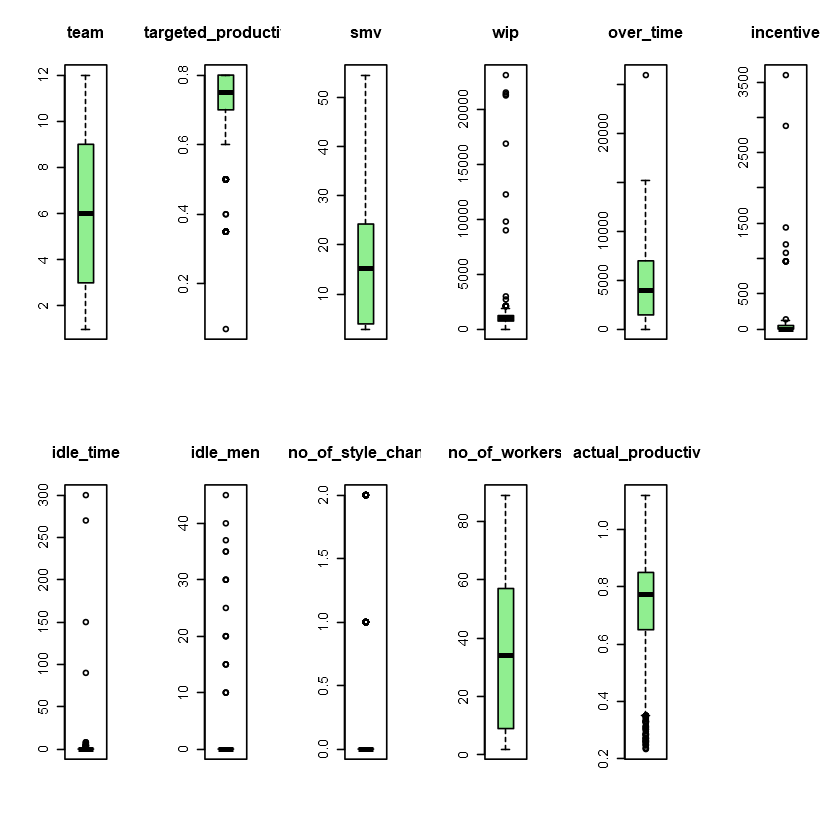

In [11]:
# plot boxplots of numeric variables
par(mfrow = c(2,6)) # 6 x 2 grid
for (i in 5:(length(garments))) {
        boxplot(garments[,i], main = names(garments[i]), type="l", col = 'lightgreen')
}

The above plots show the skew of **wip**, **incentive**, **idle_time** and **idle_men**. There are also some outliers in **targeted_productivity** and **actual_productivity** while **smv** also has more data points at the lower end of the scale.

As the numerical value of team does not convey meaning, it can be converted to a factor variable:

In [12]:
# Change team to factor
garments$team <- as.factor(garments$team)

Some outliers are also removed to assist in visualisations:

In [13]:
# Remove outliers for visualisation
garments <- garments[!(garments$incentive > 120),]
garments <- garments[!(garments$wip > 2200),]
garments <- garments[!(garments$over_time > 25000),]
garments <- garments[!(garments$idle_time > 50),]

The following bar charts and histograms also show distributions of the variables:

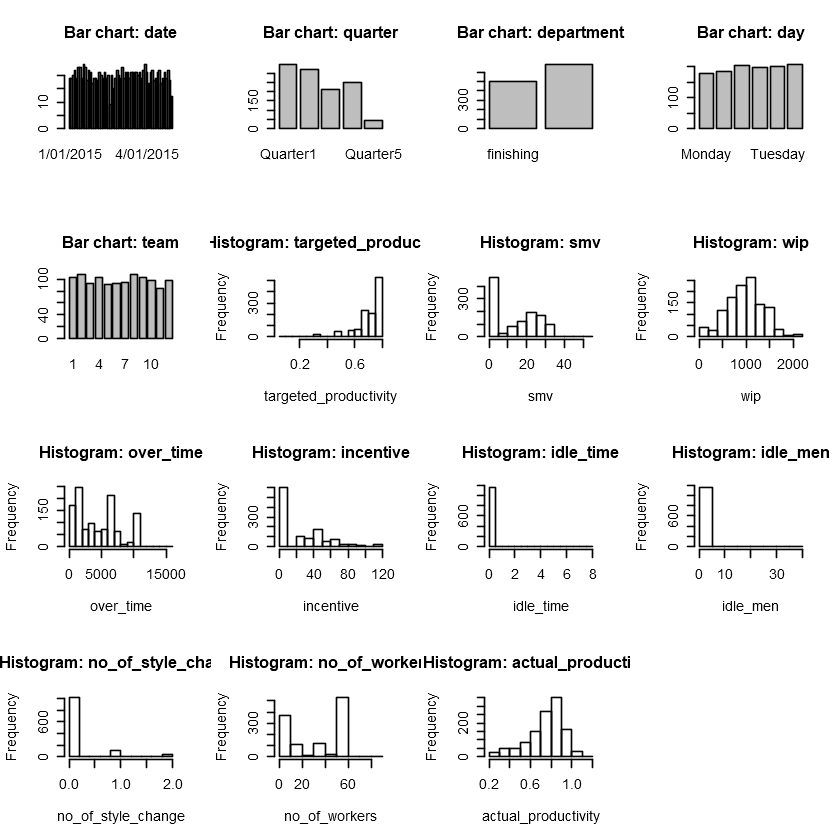

In [14]:
# Prepare grid
par(mfrow = c(4,4))

# Plot the distributions of each variable
for (i in 1:5){
    plot(garments[,i], main=paste("Bar chart:", colnames(garments[i])))
}

for (i in 6:ncol(garments)){
    hist(garments[,i], main=paste("Histogram:", colnames(garments[i])), 
         xlab=colnames(garments[i]))
}

From the above, the target variable **actual_productivity** looks close to normal with a bit of negative skew while **targeted_productivity** has stronger negative skew. **smv** **incentive** are possibly bimodal distributions as part of them look normally distributed while there are a high number of smaller values. **wip** looks somewhat close to a normal distribution while **over_time** does not. **idle_time**, **idle_men** and **no_of_style_change** are clearly not normally distributed. The histograms of the logs are shown below:

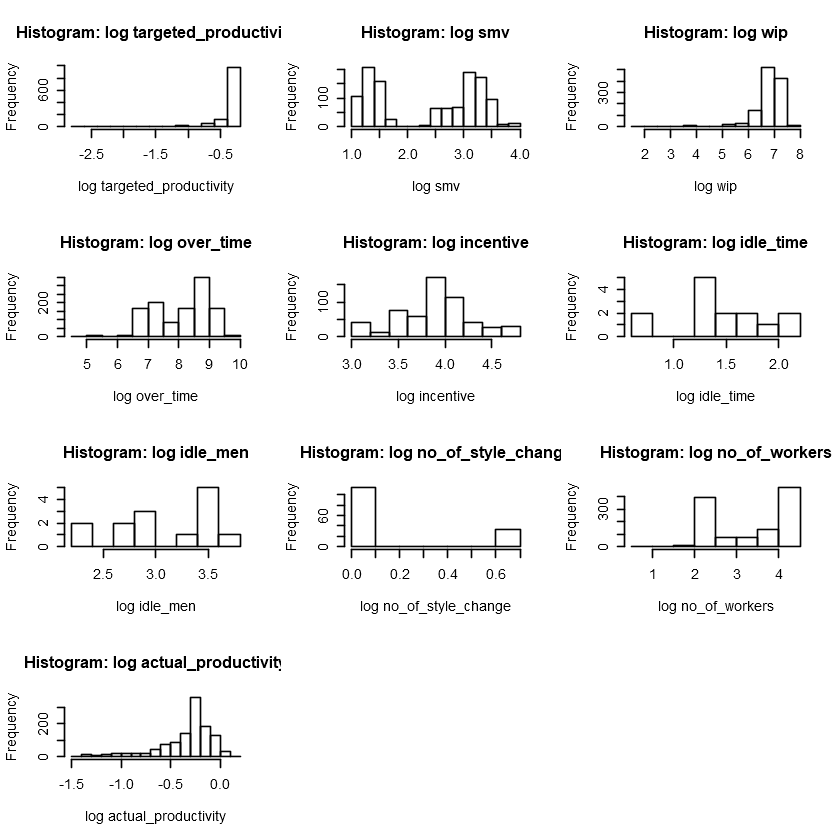

In [15]:
# Grid layout
par(mfrow = c(4,3))

# Plot histogram of log of variables
for (i in 6:ncol(garments)){
    hist(log(garments[,i]), main=paste("Histogram: log", colnames(garments[i])), 
         xlab=paste("log", colnames(garments[i])))
}

Without 0 values, log of **incentive** looks more like a normal distribution while **smv** looks like two somewhat normal distributions.

#### Scatterplot matrices

The following function is from this unit's resources and is used to combine the scatterplot matrix with colour/size encoded circles to represent correlation:

In [16]:
# From various FIT5149 learning materials
# DIY correlation plot
# http://stackoverflow.com/questions/31709982/how-to-plot-in-r-a-correlogram-on-top-of-a-correlation-matrix

colorRange <- c('#69091e', '#e37f65', 'white', '#aed2e6', '#042f60')
## colorRamp() returns a function which takes as an argument a number
## on [0,1] and returns a color in the gradient in colorRange
myColorRampFunc <- colorRamp(colorRange)

panel.cor <- function(w, z, ...) {
    correlation <- cor(w, z)

    ## because the func needs [0,1] and cor gives [-1,1], we need to shift and scale it
    col <- rgb(myColorRampFunc((1 + correlation) / 2 ) / 255 )

    ## square it to avoid visual bias due to "area vs diameter"
    radius <- sqrt(abs(correlation))
    radians <- seq(0, 2*pi, len = 50) # 50 is arbitrary
    x <- radius * cos(radians)
    y <- radius * sin(radians)
    ## make them full loops
    x <- c(x, tail(x,n=1))
    y <- c(y, tail(y,n=1))

    ## trick: "don't create a new plot" thing by following the
    ## advice here: http://www.r-bloggers.com/multiple-y-axis-in-a-r-plot/
    ## This allows
    par(new=TRUE)
    plot(0, type='n', xlim=c(-1,1), ylim=c(-1,1), axes=FALSE, asp=1)
    polygon(x, y, border=col, col=col)
}

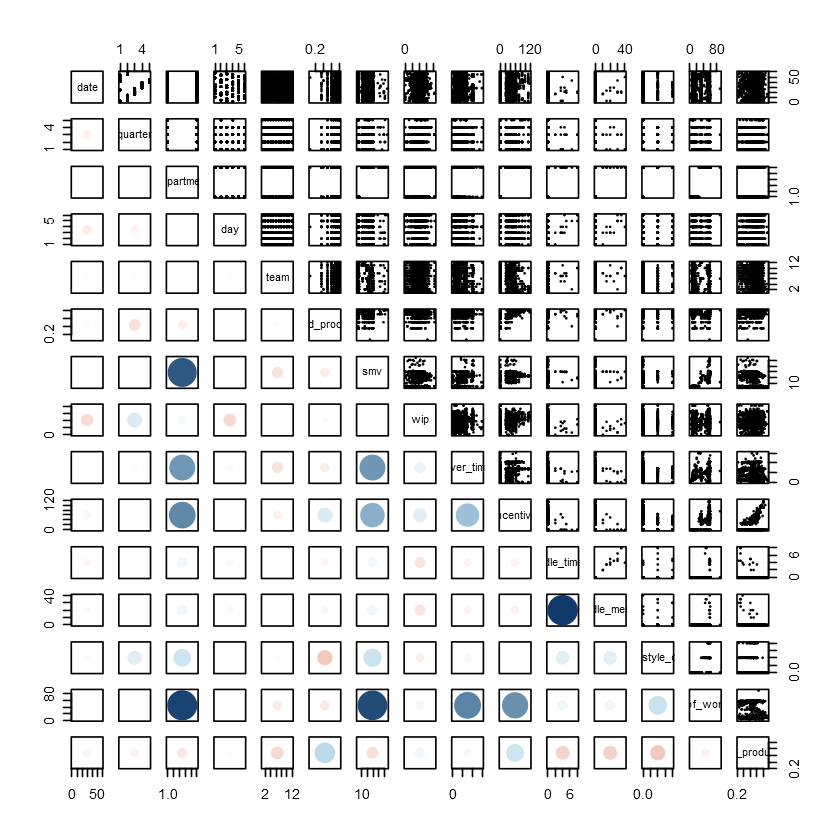

In [17]:
pairs(garments, cex=0.01, lower.panel=panel.cor)

The above splom correlation shows that some predictor variables have positive correlations with each other:
- **department**, **over_time**, **incentive** & **no_of_workers** are all positively correlated with one another.
- **idle_time** and **idle_men** are strongly positively correlated, which makes sense.
- The only noticeable correlation of a predictor variable with the target variable is for **targeted_productivity**, which seems logical. The correlation is only mild however.

Reproducing the splom for non-zero **incentive** values produces the following output:

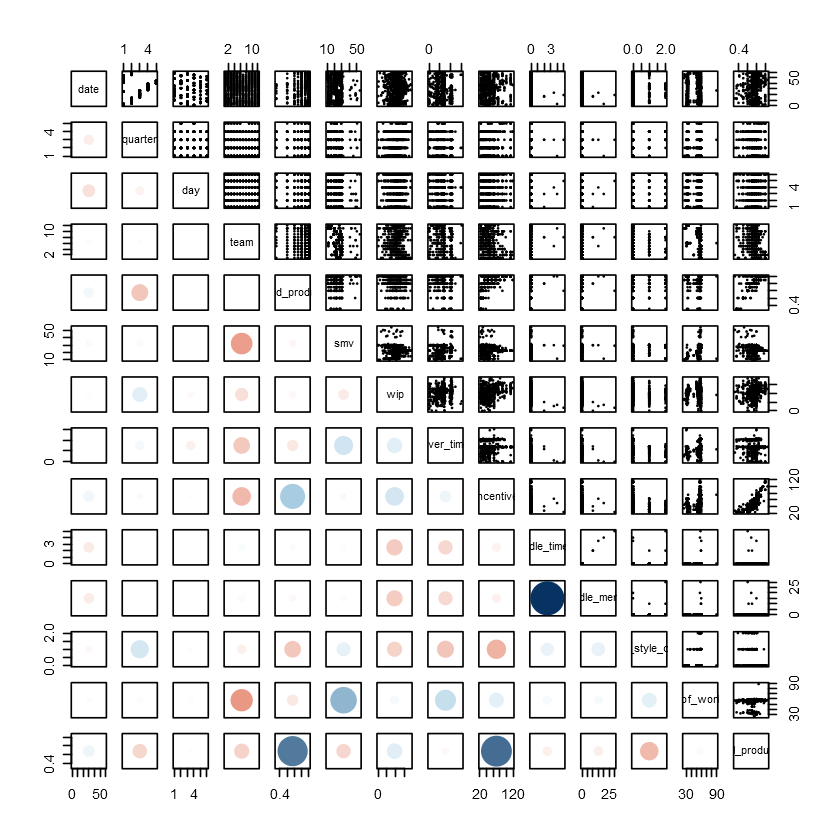

In [18]:
pairs(garments[garments$incentive!=0,-3], cex=0.01, lower.panel=panel.cor)

When a financial incentive is on offer, the correlation of both **targeted_productivity** and **incentive** with **actual_productivity** is much stronger and possibly non-linear. There is also some correlation between the two predictor variables. Next we look at the splom for the 'sewing' department:

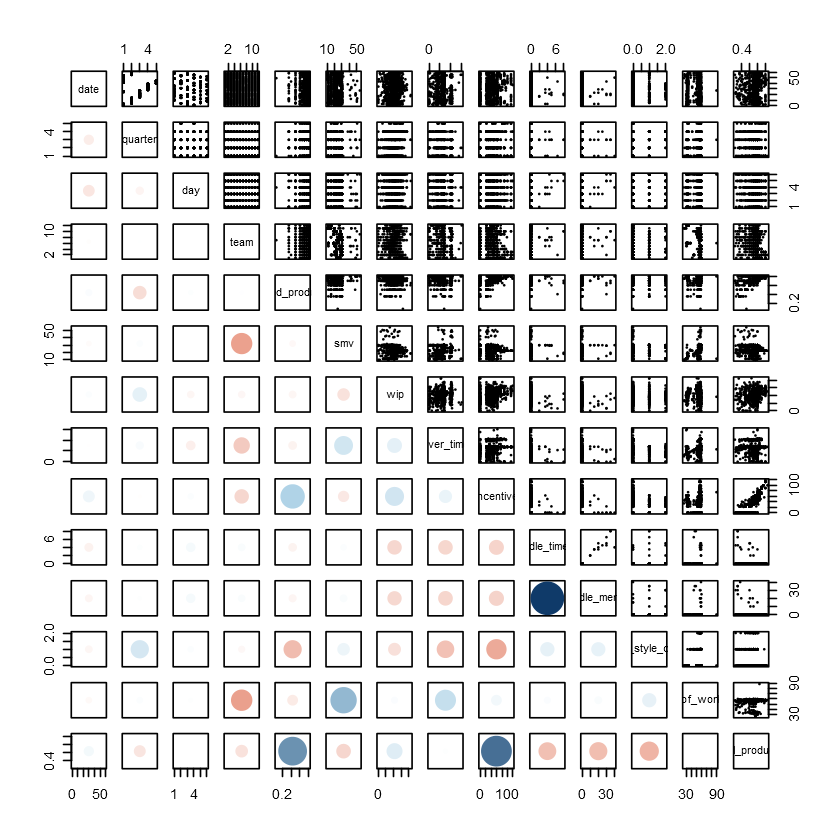

In [19]:
pairs(garments[garments$department=="sewing",-3], cex=0.01, lower.panel=panel.cor)

The same correlations show up when the data is filtered to the 'sewing' department only.

Below are the correlation matrices for each of the scatterplot matrices (numerical variables only).

In [20]:
cor(garments[6:15])

,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
targeted_productivity,1.00000000,-0.06844463,-0.02489444,-0.06964693,0.216090978,-0.04309326,-0.03712854,-0.214569445,-0.08277280,0.41231381
smv,-0.06844463,1.00000000,0.01403365,0.68511499,0.606200390,0.08865869,0.09499135,0.318997713,0.91158650,-0.12339007
wip,-0.02489444,0.01403365,1.00000000,0.10973855,0.185553031,-0.10667654,-0.10380565,-0.063391759,0.06455320,0.08717354
over_time,-0.06964693,0.68511499,0.10973855,1.00000000,0.552103956,-0.04117269,-0.04303375,0.061048929,0.74045003,-0.04072679
incentive,0.21609098,0.60620039,0.18555303,0.55210396,1.000000000,-0.05133034,-0.05341941,0.006411917,0.70114880,0.30361205
idle_time,-0.04309326,0.08865869,-0.10667654,-0.04117269,-0.051330343,1.00000000,0.96736110,0.170944192,0.09187296,-0.17221174
idle_men,-0.03712854,0.09499135,-0.10380565,-0.04303375,-0.053419406,0.96736110,1.00000000,0.168937074,0.09466092,-0.17770418
no_of_style_change,-0.21456945,0.31899771,-0.06339176,0.06104893,0.006411917,0.17094419,0.16893707,1.000000000,0.33278089,-0.21240867
no_of_workers,-0.08277280,0.91158650,0.06455320,0.74045003,0.701148801,0.09187296,0.09466092,0.332780893,1.00000000,-0.05797547
actual_productivity,0.41231381,-0.12339007,0.08717354,-0.04072679,0.303612051,-0.17221174,-0.17770418,-0.212408674,-0.05797547,1.00000000


In [21]:
cor(garments[6:15][garments$incentive!=0,])

,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
targeted_productivity,1.00000000,-0.03477571,-0.03176927,-0.08975611,0.51816025,-0.02057971,-0.02885681,-0.2159383,-0.08958697,0.77086983
smv,-0.03477571,1.00000000,-0.07818218,0.28753618,-0.02762710,0.03057449,0.03084593,0.1480427,0.58696782,-0.15488759
wip,-0.03176927,-0.07818218,1.00000000,0.18226950,0.27442308,-0.20341841,-0.19875102,-0.1738099,0.05233339,0.18747123
over_time,-0.08975611,0.28753618,0.18226950,1.00000000,0.09916177,-0.15216976,-0.14971841,-0.2254265,0.35631384,-0.03268743
incentive,0.51816025,-0.02762710,0.27442308,0.09916177,1.00000000,-0.04941218,-0.05482064,-0.2970891,0.16921922,0.80926280
idle_time,-0.02057971,0.03057449,-0.20341841,-0.15216976,-0.04941218,1.00000000,0.99210461,0.1290451,0.05553035,-0.05931336
idle_men,-0.02885681,0.03084593,-0.19875102,-0.14971841,-0.05482064,0.99210461,1.00000000,0.1401053,0.05342081,-0.06336274
no_of_style_change,-0.21593834,0.14804266,-0.17380995,-0.22542654,-0.29708905,0.12904507,0.14010535,1.0000000,0.16412815,-0.26777992
no_of_workers,-0.08958697,0.58696782,0.05233339,0.35631384,0.16921922,0.05553035,0.05342081,0.1641282,1.00000000,0.03626116
actual_productivity,0.77086983,-0.15488759,0.18747123,-0.03268743,0.80926280,-0.05931336,-0.06336274,-0.2677799,0.03626116,1.00000000


In [22]:
cor(garments[garments$department=='sewing',-c(1:5)])

,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
targeted_productivity,1.00000000,-0.02585335,-0.03710376,-0.04878372,0.48982700,-0.04766350,-0.04003775,-0.2598180,-0.08001549,0.69595461
smv,-0.02585335,1.00000000,-0.11257389,0.28172784,-0.08840165,0.02490703,0.03779261,0.1134973,0.57852059,-0.16007650
wip,-0.03710376,-0.11257389,1.00000000,0.16785203,0.28660340,-0.15638686,-0.15238904,-0.1196843,0.02963495,0.19557931
over_time,-0.04878372,0.28172784,0.16785203,1.00000000,0.12660843,-0.15788009,-0.16090409,-0.2404256,0.35659266,0.01540207
incentive,0.48982700,-0.08840165,0.28660340,0.12660843,1.00000000,-0.16867620,-0.17184968,-0.3304566,0.07956335,0.80410189
idle_time,-0.04766350,0.02490703,-0.15638686,-0.15788009,-0.16867620,1.00000000,0.96710768,0.1519819,0.02953268,-0.24755091
idle_men,-0.04003775,0.03779261,-0.15238904,-0.16090409,-0.17184968,0.96710768,1.00000000,0.1498334,0.03788153,-0.25580529
no_of_style_change,-0.25981798,0.11349727,-0.11968432,-0.24042558,-0.33045663,0.15198190,0.14983343,1.0000000,0.15030104,-0.29208902
no_of_workers,-0.08001549,0.57852059,0.02963495,0.35659266,0.07956335,0.02953268,0.03788153,0.1503010,1.00000000,0.00342480
actual_productivity,0.69595461,-0.16007650,0.19557931,0.01540207,0.80410189,-0.24755091,-0.25580529,-0.2920890,0.00342480,1.00000000


The correlation between **targeted_productivity** and **actual_productivity** is 0.42 for the whole dataset but around 0.77 when considering only when incentives are on offer. The correlation betwen **incentive** and **actual_productivity** jump from 0.09 to 0.8 when only considering the sewing department.

Taking a closer look at the scatterplots:

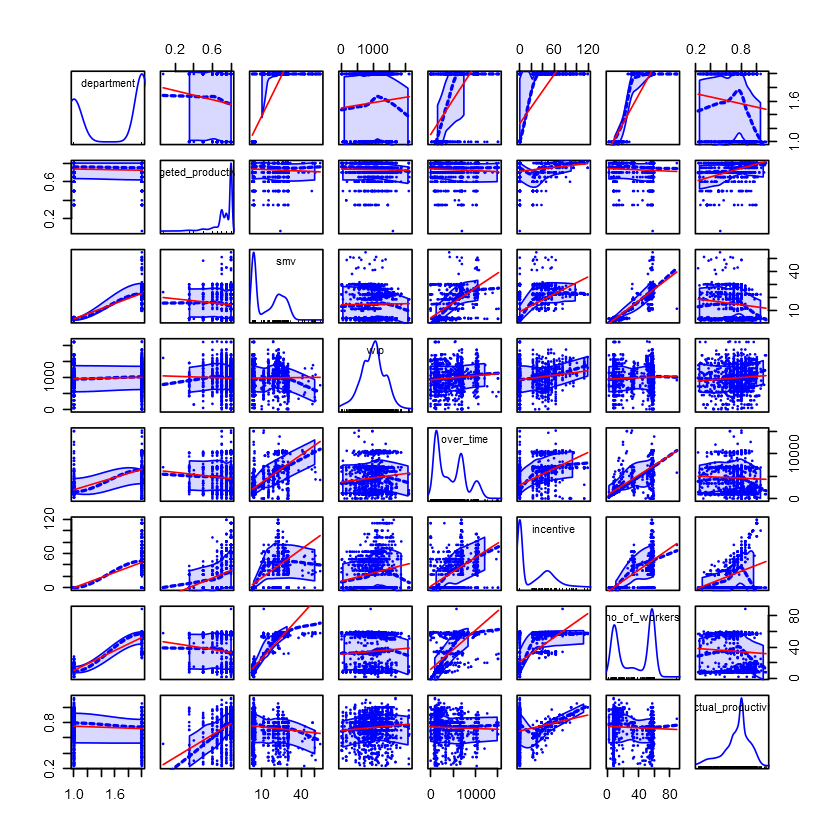

In [23]:
scatterplotMatrix(garments[c(3,6:10,14,15)], cex=0.01,
                 regLine = list(col = "red", lwd = 1))

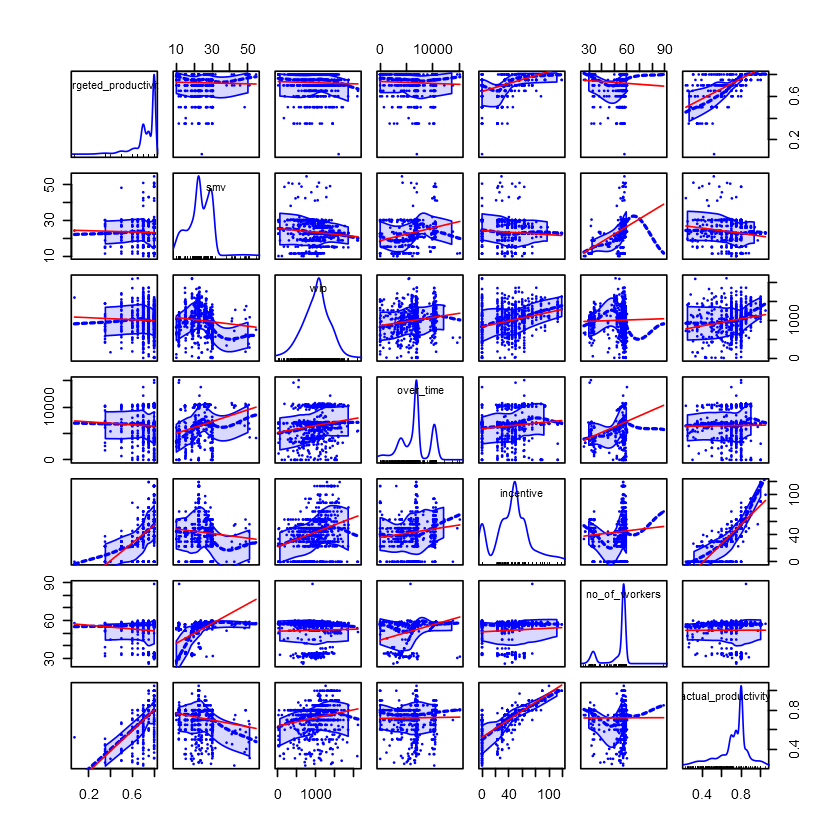

In [24]:
scatterplotMatrix(garments[garments$department=="sewing",][c(6:10,14,15)], cex=0.01,
                 regLine = list(col = "red", lwd = 1))

Warning message in smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE, :
"could not fit smooth"

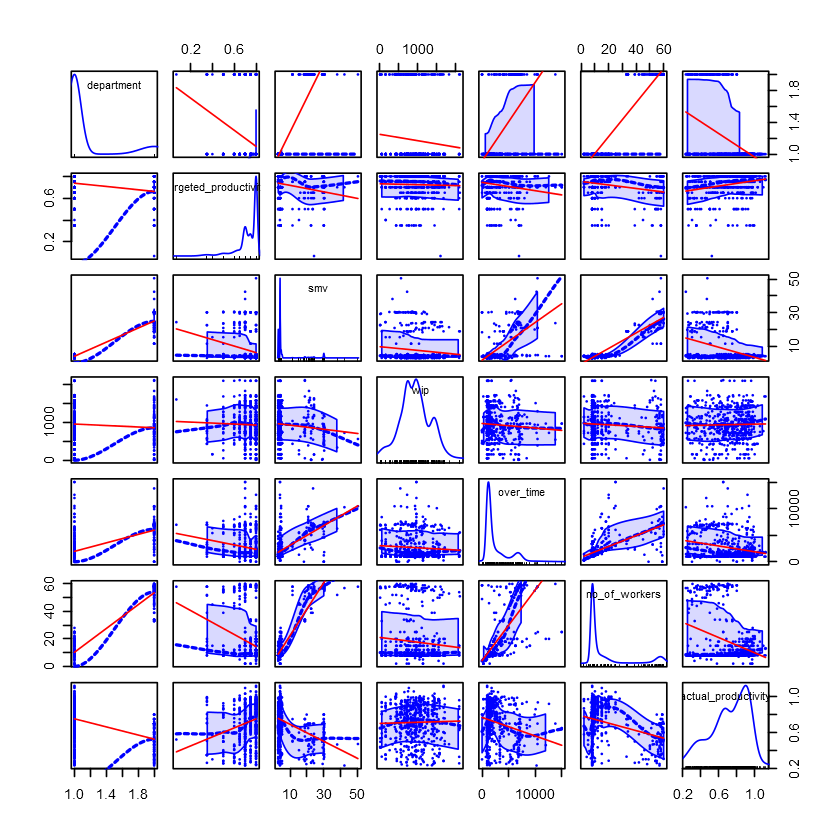

In [25]:
scatterplotMatrix(garments[garments$incentive == 0,][c(3,6:9,14,15)], cex=0.01,
                 regLine = list(col = "red", lwd = 1))

The relationship between **actual_productivity** and **incentive**, ignoring 0s, shows a clear relationship, possibly non-linear. There also other non-linear relationships, most notably:
- **no_of_workers** and **incentive**
- **incentive** and **smv**
- **no_of_workers** and **smv**

### Explore relationships between predictor variables and categories of categorical variables

Next we want to visualise some distributions of predictors by various categorical variables

In [26]:
# Reorder days
garments$day <- factor(garments$day, levels = c("Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday"))

# Convert to long format for visualisation
garments.long <- melt(garments)
head(garments.long)

Using date, quarter, department, day, team as id variables


date,quarter,department,day,team,variable,value
1/01/2015,Quarter1,sewing,Thursday,8,targeted_productivity,0.80
1/01/2015,Quarter1,finishing,Thursday,1,targeted_productivity,0.75
1/01/2015,Quarter1,sewing,Thursday,11,targeted_productivity,0.80
1/01/2015,Quarter1,sewing,Thursday,12,targeted_productivity,0.80
1/01/2015,Quarter1,sewing,Thursday,6,targeted_productivity,0.80
1/01/2015,Quarter1,sewing,Thursday,7,targeted_productivity,0.80


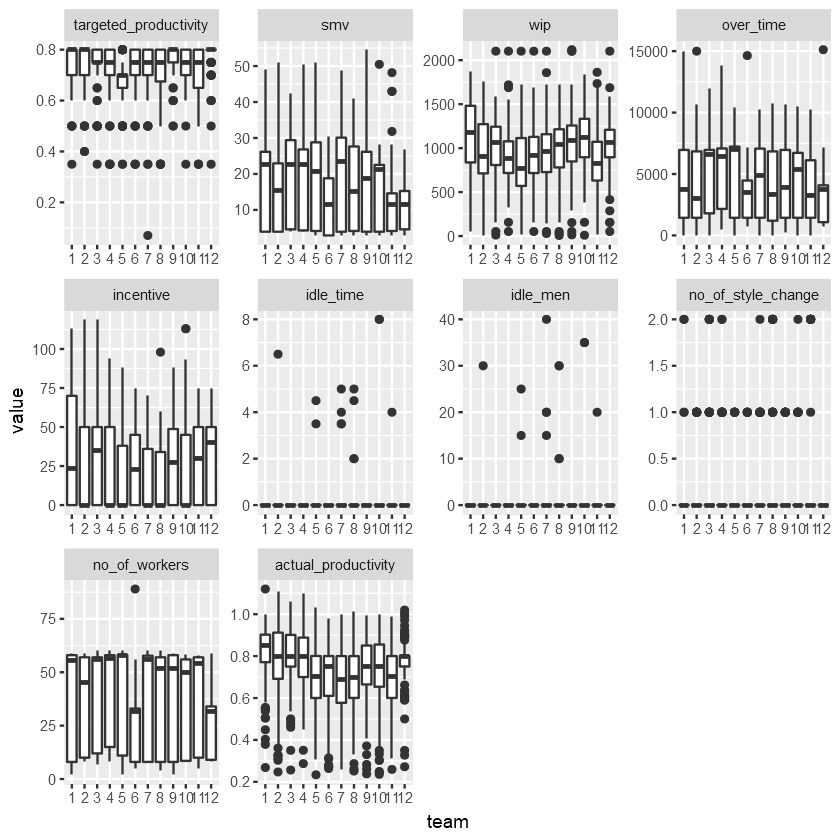

In [27]:
# Plot boxplots of attributes by team
ggplot(garments.long, aes(x = team, y = value)) +
facet_wrap(~variable, scales="free") +
geom_boxplot()

#### Teams
- The targeted productivity is fairly consistent except for team 5, which tends to have lower targets and team 12 who has more consistently higher targets of 0.8.
- The standard minute values vary less for teams 8, 11 & 12 and are lower overall than for other teams.
- Teams 5 and 11 have the lowest median wip while team 1 has the highest. Team 1 also has a greater IQR of wip (unfinished items for products).
- Teams 6 and 12 have consistently lower overtime compared to other teams. Teams 3, 4, 5, 7 & 10 often have greater minutes of overtime.
- Incentives are offered to all teams but teams 7 & 8 are offered less on average and teams 2, 4, 5, 7 & 8 are proportionally more offered 0 incentive. Team 1 is more frequently offered higher incentives while team 12 is offered more consistently offered above average incentives.
- Teams 5 and 12 generally have fewer workers to the other teams, who all have similar numbers of workers.
- Actual productivity of team 12 is the most consistent but team 1 usually outperforms them. The productivity of teams 2-4 is also often similar to team 1 but less consistent and they would also underperform more often compared to team 1. Teams 9 & 10 would sometimes outperform and sometimes underperform compared to team 12 but overall underperform relative to teams 1-4. Teams 5-8 & 11 have generally the worst levels of productivity (although team 6 is slightly better).

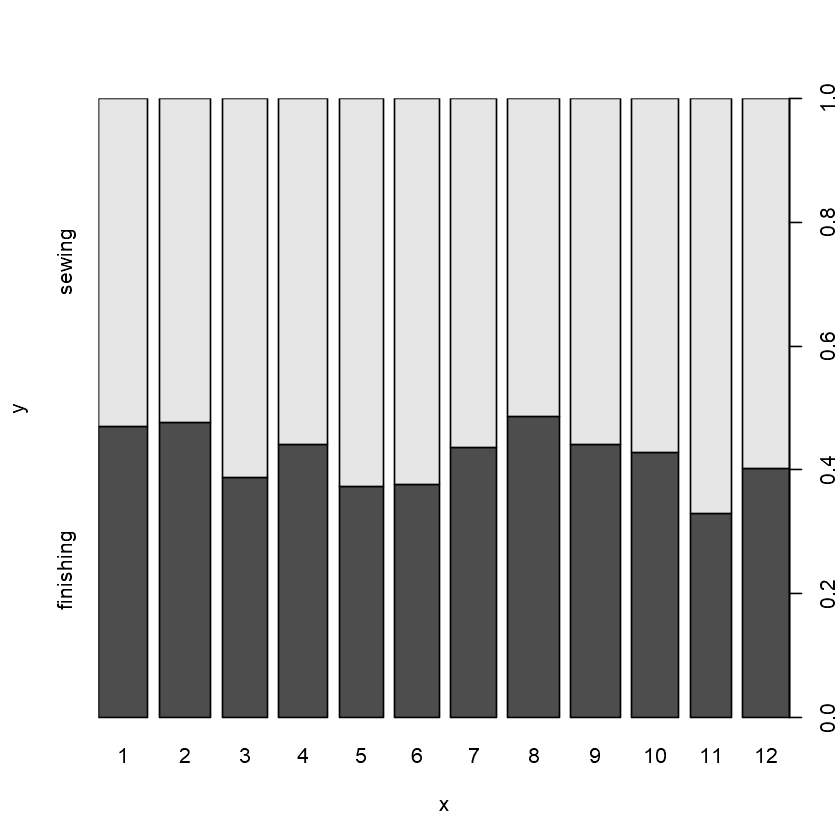

In [28]:
# Plot stacked percentage bar chart of deparments by team
plot(garments.long$team, garments.long$department)

From the original summary of the data we know that there are more instances of the sewing department than finishing, which is also the case for each team. Team 11 has the highest proportion of sewing observations relative to finishing and team 8 has the lowest.

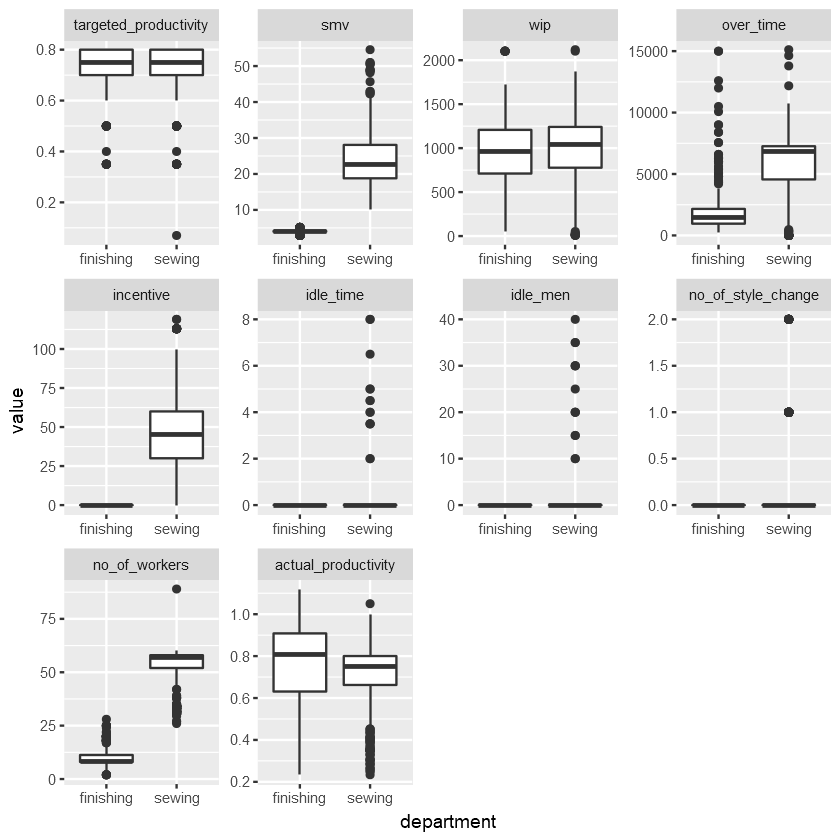

In [29]:
# Plot boxplots of attributes by department
ggplot(garments.long, aes(x = department, y = value)) +
facet_wrap(~variable, scales="free") +
geom_boxplot()

#### Departments
- There is little difference in targeted productivity between the finishing and sewing departments.
- The smv (time taken for a task) is much lower for finishing than it is for sewing.
- The number of unfinished items for products (wip) is similar for both finishing and sewing departments (though slightly lwoer for finishing).
- There is much less overtime for finishing than sewing.
- Incentives are much lower for finishing than for sewing.
- Production interruptions (idle_time and idle_men) are only present in the sewing department. Likewise style changes are only relevant to the sewing department however they are mostly 0.
- There are more workers in the sewing department than the finishing department.
- The actual productivity is, on average, a bit higher for the finishing department than the sewing department but also varies more, whereas the sewing department productivity is more consistent. From the other features, it seems that sewing is more labour intensive, prone to production interruption and requires more workers.

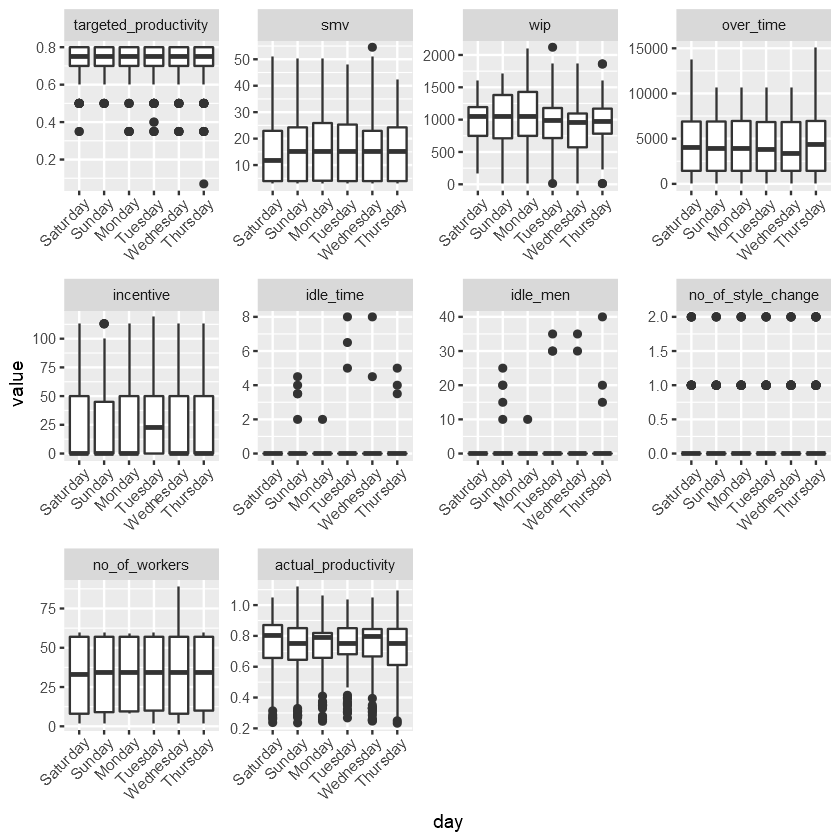

In [30]:
# Plot boxplots of attributes by day
ggplot(garments.long, aes(x = day, y = value)) +
facet_wrap(~variable, scales="free") +
geom_boxplot() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

- Targeted productivity, SMV and overtime is fairly consistent over the week although the median of standard minute values is a little lower on Saturdays compared to other days. There are also a few occassions of high amounts of overtime on some Saturdays and Thursdays.
- WIP is relatively consistent, although Sundays and Mondays more often have a higher WIP while Wednesdays more often have a lower WIP.
- The amount of incentives are similar for each day.
- The number of workers are generally consistent each day.
- Actual productivity is also relatively consistent by day.

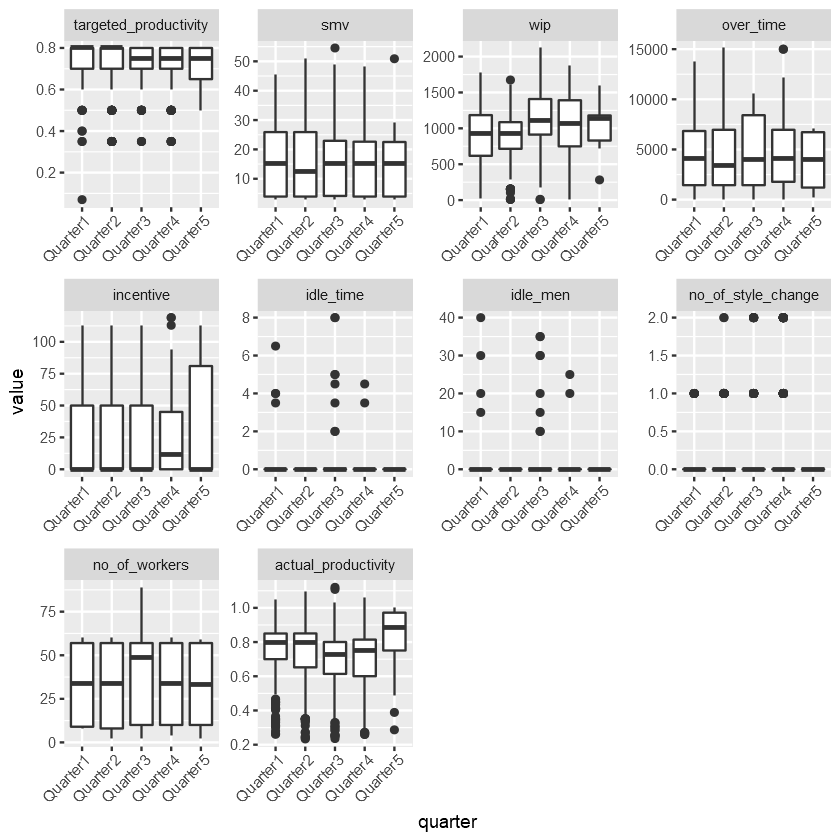

In [31]:
# Plot boxplots of attributes by quarter
ggplot(garments.long, aes(x = quarter, y = value)) +
facet_wrap(~variable, scales="free") +
geom_boxplot() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

- Targeted productivity is similar for each "quarter" (period of the month), although the median target is a bit lower in the back half of the month.
- SMV and overtime is fairly similar for each quarter, the median SMV and overtime is slightly lower in Quarter 2.
- WIP is higher in Quarters 3 and 4, generally the second half of the month.
- Incentives are similar by quarter except for quarter 5 where there are more higher incentives. Quarter 5 however, only consists of a small number of data points covering 29 January to 31 January.
- There are more cases of idle time in Quarter 1 than other quarters.
- There are no cases of idle time or idle men in quarter 2.
- There are more instances of a higher number of workers in Quarter 3.
- The actual productivity is slightly lower for quarters 3 & 4 compared to quarters 1 & 2, as was the target productivity. Quarter 5 had higher levels of productivity, which could be a late scramble to meet targets, although this doesn't hold for quarter 4.

In [32]:
# Amend dates so they can be visualised in chronological order
garments.long$date <- as.factor(as.Date(garments.long$date, format = "%d/%m/%y",
        optional = FALSE))

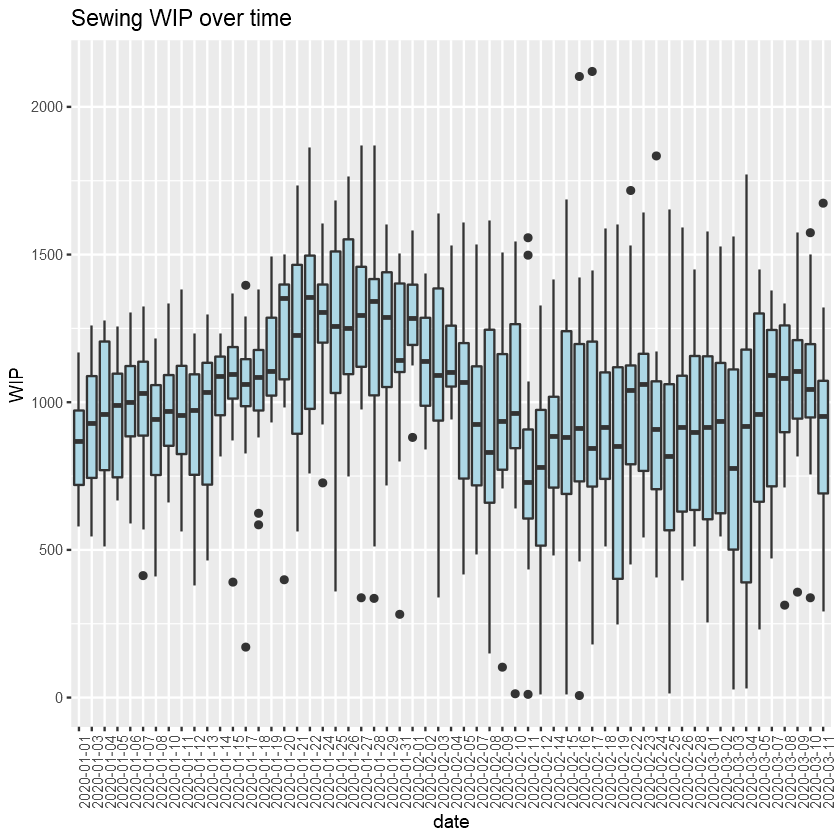

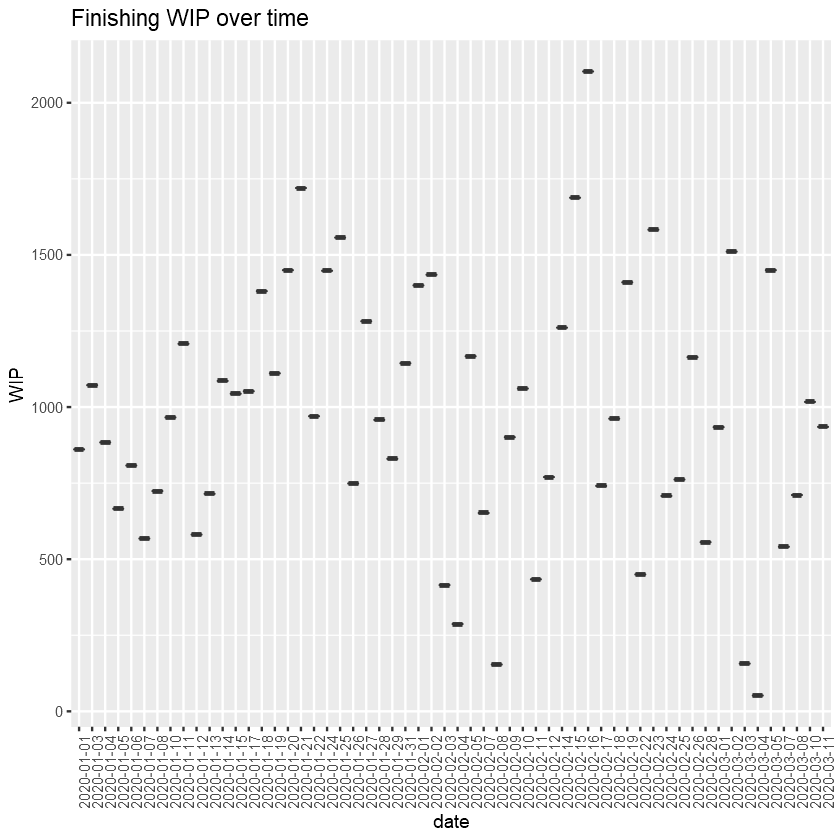

In [33]:
# Plot WIP by date for sewing and finishing departments (boxplots)
par(mfrow = c(2,1))

ggplot(garments.long[(garments.long$variable=="wip" & garments.long$department=="sewing"),], 
       aes(x = date, y = value)) +
geom_boxplot(fill="lightblue") +
labs(title="Sewing WIP over time", y="WIP") +
theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1))

ggplot(garments.long[(garments.long$variable=="wip" & garments.long$department=="finishing"),], 
       aes(x = date, y = value)) +
geom_boxplot(fill="lightblue") +
labs(title="Finishing WIP over time", y="WIP") +
theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1))

From the above it appears that WIP for finishing department is the summation across all teams each day as there is no variation in values, whereas for sewing it is not aggregated.

Previously we looked at boxplots by department, we can also visualise as density plots or histograms:

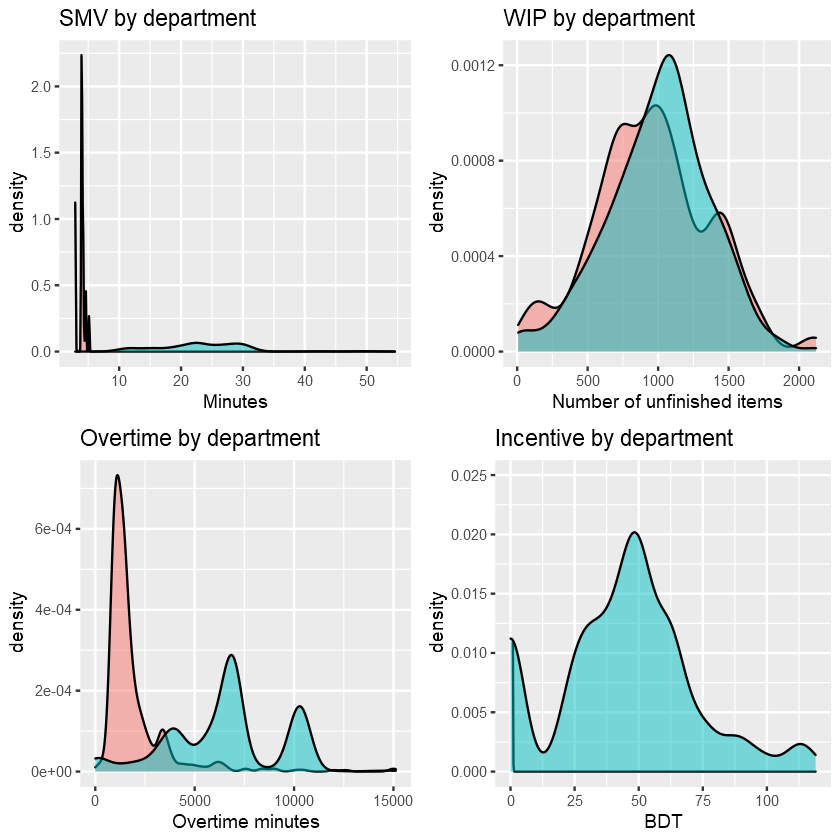

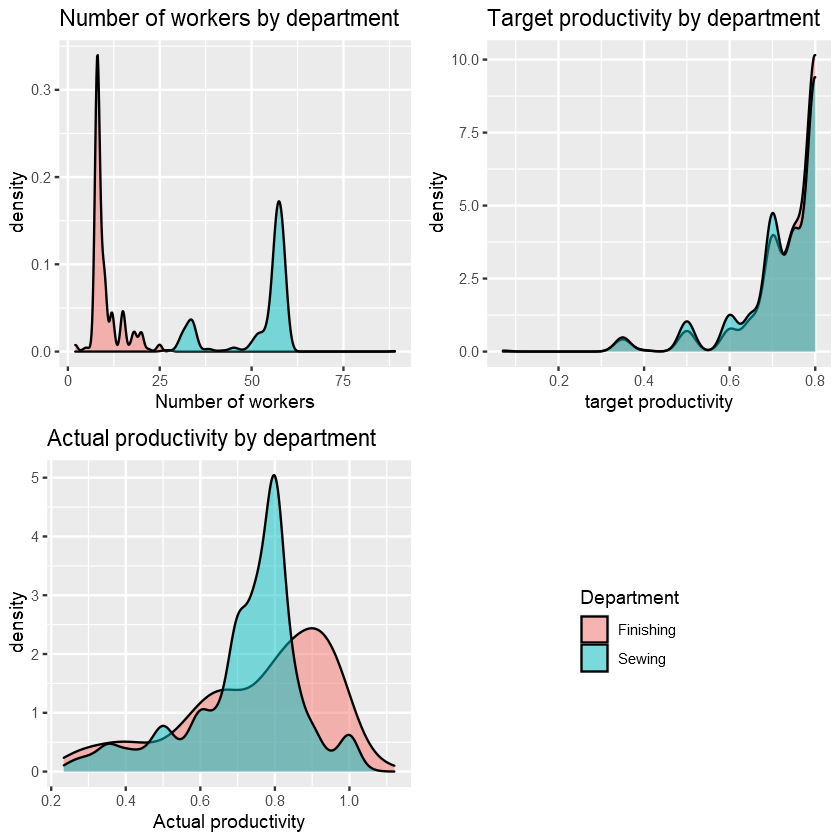

In [34]:
# Density plots by departments, using code from house_price_prediction FIT5149 learning resource

p1 <- ggplot(garments.long[garments.long$variable=="smv",], 
       aes(x=value)) + 
    geom_density(aes(fill = department), alpha=0.5) +
    ggtitle('SMV by department') +
    labs(x="Minutes") +
    scale_fill_discrete(guide="none")

p2 <- ggplot(garments.long[garments.long$variable=="wip",],
             aes(x=value)) + 
    geom_density(aes(fill = department), alpha=0.5) +
    ggtitle('WIP by department') +
    labs(x="Number of unfinished items") +
    scale_fill_discrete(guide="none")

p3 <- ggplot(garments.long[garments.long$variable=="over_time",],
             aes(x=value)) + 
    geom_density(aes(fill = department), alpha=0.5) +
    ggtitle('Overtime by department') +
    labs(x="Overtime minutes") +
    scale_fill_discrete(guide="none")

p4 <- ggplot(garments.long[garments.long$variable=="incentive",],
             aes(x=value)) + 
    geom_density(aes(fill = department), alpha=0.5) +
    ylim(0, 0.025) +
    ggtitle('Incentive by department') +
    labs(x="BDT") +
    scale_fill_discrete(guide="none")

p5 <- ggplot(garments.long[garments.long$variable=="no_of_workers",],
             aes(x=value)) + 
    geom_density(aes(fill = department), alpha=0.5) +
    ggtitle('Number of workers by department') +
    labs(x="Number of workers") +
    scale_fill_discrete(name="Department", labels=c("Finishing","Sewing"))

p6 <- ggplot(garments.long[garments.long$variable=="targeted_productivity",],
             aes(x=value)) + 
    geom_density(aes(fill = department), alpha=0.5) +
    ggtitle('Target productivity by department') +
    labs(x="target productivity") +
    scale_fill_discrete(guide="none")

p7 <- ggplot(garments.long[garments.long$variable=="actual_productivity",],
             aes(x=value)) + 
    geom_density(aes(fill = department), alpha=0.5) +
    ggtitle('Actual productivity by department') +
    labs(x="Actual productivity") +
    scale_fill_discrete(guide="none")

tmp <- ggplot_gtable(ggplot_build(p5))
leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
legend <- tmp$grobs[[leg]]

grid.arrange(p1, p2, p3, p4)                                    
grid.arrange(p5+theme(legend.position = 'none'), p6, p7,
             legend, nrow=2, ncol=2)

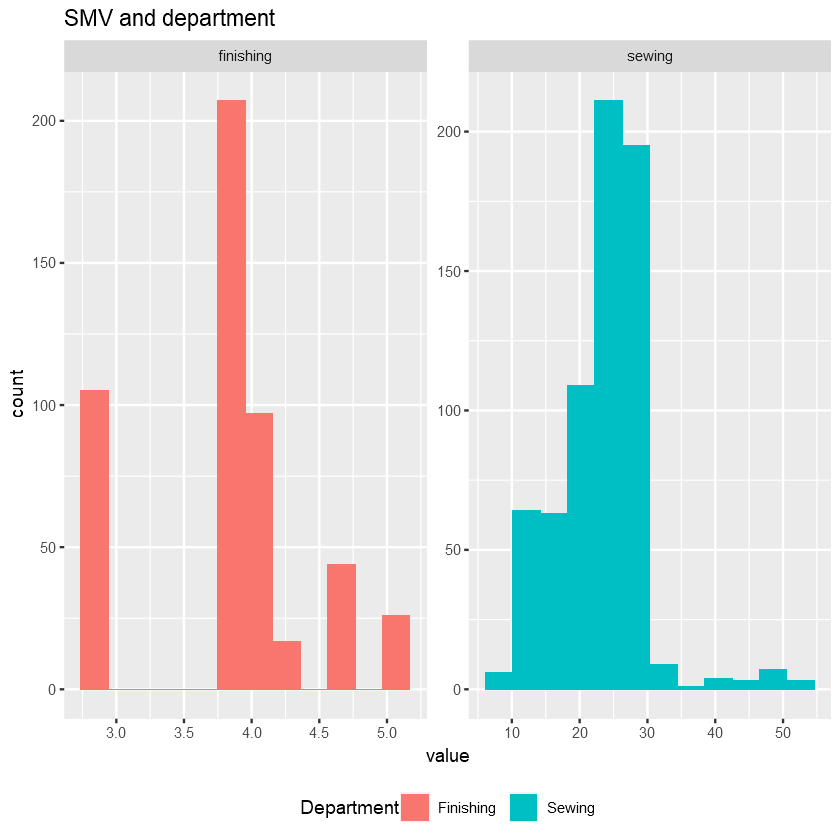

In [35]:
# To more clearly see SMV plots, separately, as histograms
ggplot(garments.long[(garments.long$variable=="smv"),],
       aes(x=value, fill=department)) +
    facet_wrap(~department, scales="free") +
    geom_histogram(bins=12) +
    ggtitle('SMV and department') +
    theme(legend.position = "bottom") +
    scale_fill_discrete(name="Department", labels=c("Finishing","Sewing"))

The plots above reaffirm what the boxplots showed earlier, but in more detail. WIP has a similar distribution for each department, being close to normal. Target productivity is almost identical by department. Other numerical variables have different distributions for the two departments. SMV when split by department is still not quite normal.

## 3. Methodology<a class="anchor" id="sec_4"></a>

To develop the models the following steps will be taken:

- the garments data will be read in again and minor tidying up (e.g. factorise the team attribute).
- the dataset will be split randomly into a training and testing set 80/20.
- linear models will be developed by a combination of manual consideration of attributes from the EDA phase as well as stepwise selection or lasso regularisation if necessary to assist with feature selection.
- linear models are preferred due to their inference capabilities.
- From the correlation and distribution plots in EDA, some interaction terms and transformations will be considered.
- while building the models, cross-validation will be used with 10 folds to evaluate the performance of the models and reduce the variability of results compared to the validation set approach and without being overly computationally expensive, as with leave one out cross validation.
- Residual plots will be checked for assumptions of normality of errors, homoskedacity, etc.
- The final models will be run on the test set and the root mean square error calculated for each to compare performance.

## 4. Model Development <a class="anchor" id="sec_5"></a>

In [36]:
# Function to calculate root mean square error
rmse <- function(prediction, target){
    return (sqrt(mean((prediction - target)^2)))
}

In [37]:
# Function to calculate the mean absolute error
mae <- function(prediction, target){
    return (mean(abs(prediction - target)))
}

Here we read in the data again, tidy up a few things again, change date feature to Date type and change team feature to factor. We also perform an 80/20 train/test split of the data at random.

In [38]:
# Read data again
garments <- read.csv("garments_empolyee_productivity.csv")

# Fix duplicate departments
levels(garments$department)[levels(garments$department) == "finishing "] = "finishing"

# Fix typo "sweing" to "sewing"
levels(garments$department)[levels(garments$department) == "sweing"] = "sewing"

# Change team to factor
garments$team <- as.factor(garments$team)

# Amend dates so they can be visualised in chronological order
garments$date <- as.Date(garments$date, format = "%d/%m/%y",
        optional = FALSE)

# Set random seed
set.seed(42)

# Shuffle dataset
garments <- garments[sample(1:nrow(garments),nrow(garments)),]
# Create index for train/test 80/20 split
train.index = 1:round(nrow(garments)*0.8)
garments.train <- garments[train.index,]
garments.test <- garments[-train.index,]
garments.test.label <- garments.test[,'actual_productivity']

### Model 1

First we begin with a linear model of all features:

In [39]:
# Fit basic linear model of all variables
fit1 <- lm(actual_productivity ~ ., data=garments.train)
summary(fit1)


Call:
lm(formula = actual_productivity ~ ., data = garments.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.57871 -0.06373  0.01853  0.08259  0.52805 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            1.317e+01  4.700e+00   2.802 0.005177 ** 
date                  -7.023e-04  2.567e-04  -2.736 0.006340 ** 
quarterQuarter2        3.205e-03  1.256e-02   0.255 0.798607    
quarterQuarter3       -1.296e-02  1.495e-02  -0.867 0.386231    
quarterQuarter4       -7.731e-03  1.422e-02  -0.544 0.586893    
quarterQuarter5        9.894e-02  2.748e-02   3.600 0.000335 ***
departmentsewing      -7.281e-02  3.784e-02  -1.924 0.054628 .  
daySaturday            9.221e-03  1.762e-02   0.523 0.600817    
daySunday             -1.781e-03  1.682e-02  -0.106 0.915714    
dayThursday           -1.300e-02  1.720e-02  -0.756 0.450075    
dayTuesday             1.724e-02  1.697e-02   1.016 0.310016    
dayWednesday           3.004e-03 

The adjusted $R^2$ of 0.3046 shows that there is a small amount of variation of productivity explained by the model. The F-statistic of 18.48 with a very small p-value means the model is useful.

**targeted_productivity** has the biggest effect in the model, with its coefficient indicating a 0.6549 increase in estimated actual_productivity for a one unit increase in targeted_productivity and the feature is significant as it has a very small p-value (the smallest p-value of all features in the model).

Of the numerical variables, **wip** and **idle_time** are not significant as they have large p-values (so we cannot reject the null hypothesis that their coefficients are 0). Some of the categorical dummy variables are also not significant but if any categories are significant then we should keep all dummy variables from the corresponding categorical variable. None of the dummy variables for **day** are significant.

From the boxplots earlier, there did not appear to be much difference in the distributions of other variables by **day**. From the scatterplot matrices, **wip** did not appear to have any strong correlation with other variables and **idle_time** only had a strong correlation with idle_men.

Below backwards stepwise selection is applied to the model:

In [40]:
# Apply backwards stepwise selection
fit1a <- step(fit1, direction = "back")

Start:  AIC=-3655.46
actual_productivity ~ date + quarter + department + day + team + 
    targeted_productivity + smv + wip + over_time + incentive + 
    idle_time + idle_men + no_of_style_change + no_of_workers

                        Df Sum of Sq    RSS     AIC
- day                    5    0.0832 19.817 -3661.4
- idle_time              1    0.0009 19.735 -3657.4
- wip                    1    0.0180 19.752 -3656.6
<none>                               19.734 -3655.5
- no_of_style_change     1    0.0585 19.792 -3654.6
- incentive              1    0.0671 19.801 -3654.2
- department             1    0.0789 19.813 -3653.6
- over_time              1    0.1510 19.885 -3650.2
- date                   1    0.1595 19.893 -3649.7
- quarter                4    0.3391 20.073 -3647.1
- idle_men               1    0.5079 20.242 -3633.1
- no_of_workers          1    0.6293 20.363 -3627.4
- smv                    1    0.7950 20.529 -3619.6
- team                  11    1.6381 21.372 -3601.1
- tar

In [41]:
summary(fit1a)


Call:
lm(formula = actual_productivity ~ date + quarter + department + 
    team + targeted_productivity + smv + over_time + incentive + 
    idle_men + no_of_style_change + no_of_workers, data = garments.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.57790 -0.06461  0.01813  0.08429  0.52727 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            1.293e+01  4.675e+00   2.766 0.005788 ** 
date                  -6.888e-04  2.553e-04  -2.698 0.007096 ** 
quarterQuarter2        2.871e-03  1.248e-02   0.230 0.818088    
quarterQuarter3       -1.364e-02  1.485e-02  -0.918 0.358651    
quarterQuarter4       -8.508e-03  1.419e-02  -0.600 0.548856    
quarterQuarter5        9.579e-02  2.637e-02   3.633 0.000295 ***
departmentsewing      -7.144e-02  3.776e-02  -1.892 0.058805 .  
team2                 -4.353e-02  2.294e-02  -1.897 0.058091 .  
team3                 -1.832e-02  2.322e-02  -0.789 0.430539    
team4             

**day**, **wip** and **idle_time** variables have all been removed, the adjusted $R^2$ remains unchanged and the model is still significant.

**targeted_productivity** remains the most significant variable of the model with a p-value < 2e-16, meaning the probability of observing the **actual_productivity** values by chance if the two variables were not correlated is very low and so we would reject the null hypothesis that the coefficient is zero. The EDA scatter plots and correlation matrices also showed that the clearest correlation with **actual_productivity** was **target_productivity**.

In this model, **smv**, **idle_time** and **no_of_workers** are also significant at the 0.001 level and at least 1 of the categories for **quarter** (Quarter5, although this category had few data points) and **team** (team6 - team11) are significant at this level. **over_time** and **date** are significant at the 0.01 level while **department*, **incentive** and **no_of_style_change** are borderline as they are only significant at the 0.1 level.

**targeted_productivity**, **incentive**, **no_of_workers** and **Quarter2** or **Quarter5** have positive coefficients so result in increases in predicted **actual_productivity** while every other variable reduces the predicted output. So setting higher targets, offering incentives and having more workers assigned generally leads to higher productivity. On the contrary, higher smv (time taken to complete a task), idle men and overtime negatively affect productivity. The intercept is comparatively largely positive but the predicted output is reduced by several negative variable coefficients.

Cross validation is applied to evaluate the model:

In [42]:
set.seed(42)

# Set 10 folds (90/10 splits) for cross validation 
cv <- trainControl(method = "cv", number = 10)

# Re-create model for cross-validation 
train(fit1a$call[[2]], data=garments.train, method = "lm", trControl = cv)

Linear Regression 

958 samples
 11 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 863, 861, 862, 861, 862, 863, ... 
Resampling results:

  RMSE       Rsquared  MAE      
  0.1475519  0.295079  0.1075953

Tuning parameter 'intercept' was held constant at a value of TRUE

In [43]:
# Calculate RMSE as a % of average actual_producitivity
round(0.1475519/mean(garments.train$actual_productivity),4)

[1] 0.2011

The $R^2$ of 0.2951 upon cross validation, is a little bit lower than for the training set but the model does not appear to overfit the data. The root mean square error (RMSE) is 0.1476, which represents about 20% of the average **actual_productivity**.

Below, we look at the plotted residuals:

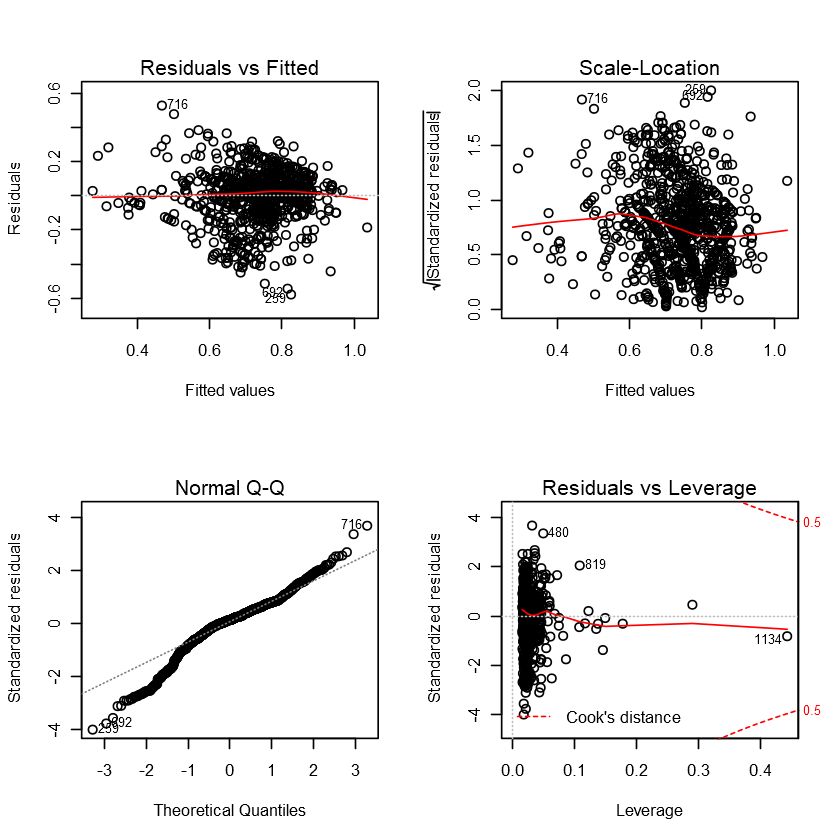

In [44]:
# Plot residuals
par(mfcol=c(2,2))
plot(fit1a)

The **Residuals vs Fitted** are mostly evenly distributed around 0 although at the lower end of the fitted values there are some larger distances above 0 so the assumption of homoskedasticity may not be completely fulfilled. The **Normal Q-Q** plot follows a straight line from theoretical quantiles between -1 and 1. Above 1 they deviate slightly and under -1 they deviate more so  the residuals aren't following a normal distribution. The **Scale-Location** plot shows a fairly equal distribution of variances. The **Residuals vs Leverage** plot does not show any influential outliers, outside of the Cook's distance line.

Using the ANOVA function to compare the original model to the modified one after stepwise selection was performed:

In [45]:
# Compare the models
anova(fit1, fit1a)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
926,19.73364,NA,NA,NA,NA
933,19.83354,-7,-0.09989894,0.6696789,0.6979115


As the p-value is large, the null hypothesis cannot be rejected, that is, the difference between the models is not statistically significant. Given that we only removed a few features one-by-one, each of which were not statistically significant, this makes sense. The pruned model is a little bit simpler as it contains 7 less variables.

We can then make predictions on the test data using the model and compare:

In [46]:
# Make predictions on test data using model 1
predictions1 <- predict(fit1a, garments.test, method = "response")

In [47]:
# Calculate RMSE of predictions
rmse1 <- rmse(predictions1, garments.test.label)
rmse1

[1] 0.1416062

In [48]:
# Calculate RMSE as a % of average actual_producitivity
round(rmse1/mean(garments.test.label),4)

[1] 0.1911

In [49]:
# Calculate MAE of predictions
mae1 <- mae(predictions1, garments.test.label)
mae1

[1] 0.1022961

In [50]:
# Calculate MAE as a % of average actual_producitivity
round(mae1/mean(garments.test.label),4)

[1] 0.1381

### Model 2

For the second model we will drop date and quarter as we didn't find too much with respect to those variables in the EDA stage. We will also try including some interaction terms. A number of numerical variables had different distributions based on whether they related to the "sewing" or "finishing" department.

In [51]:
# Create formula to call for the linear model fit
formula2 <- actual_productivity ~ . - date - quarter - day - wip + department:incentive +
            department:smv + department:over_time + department:no_of_workers + incentive:smv +
            incentive:over_time + incentive:no_of_workers + smv:over_time + smv:no_of_workers +
            idle_time:idle_men

# Fit the linear model
fit2 <- lm(formula2, garments.train)
summary(fit2)


Call:
lm(formula = formula2, data = garments.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.51831 -0.04511  0.00532  0.06591  0.38913 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     1.705e-01  6.297e-02   2.707 0.006907 ** 
departmentsewing                3.640e-01  1.539e-01   2.365 0.018216 *  
team2                          -4.009e-02  2.064e-02  -1.942 0.052404 .  
team3                          -1.535e-02  2.089e-02  -0.735 0.462662    
team4                          -3.175e-03  2.082e-02  -0.153 0.878824    
team5                          -5.558e-03  2.154e-02  -0.258 0.796424    
team6                          -7.811e-02  2.516e-02  -3.104 0.001964 ** 
team7                          -4.186e-02  2.171e-02  -1.928 0.054145 .  
team8                          -6.134e-02  2.057e-02  -2.981 0.002945 ** 
team9                          -5.056e-02  2.112e-02  -2.394 0.016849 *  
team10        

In [52]:
set.seed(42)

# Set 10 folds (90/10 splits) for cross validation
cv <- trainControl(method = "cv", number = 10)

# Re-create model for cross-validation 
train(formula2, data = garments.train, method = "lm", trControl = cv)

Linear Regression 

958 samples
 14 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 863, 861, 862, 861, 862, 863, ... 
Resampling results:

  RMSE       Rsquared   MAE       
  0.1695876  0.3838857  0.09708555

Tuning parameter 'intercept' was held constant at a value of TRUE

The $R^2$ is an improvement on model 1, indicating more variability in the response variable is explained by the predictors. The root mean square error of 0.1696 however, is worse.

Warning message in sqrt(crit * p * (1 - hh)/hh):
"NaNs produced"Warning message in sqrt(crit * p * (1 - hh)/hh):
"NaNs produced"

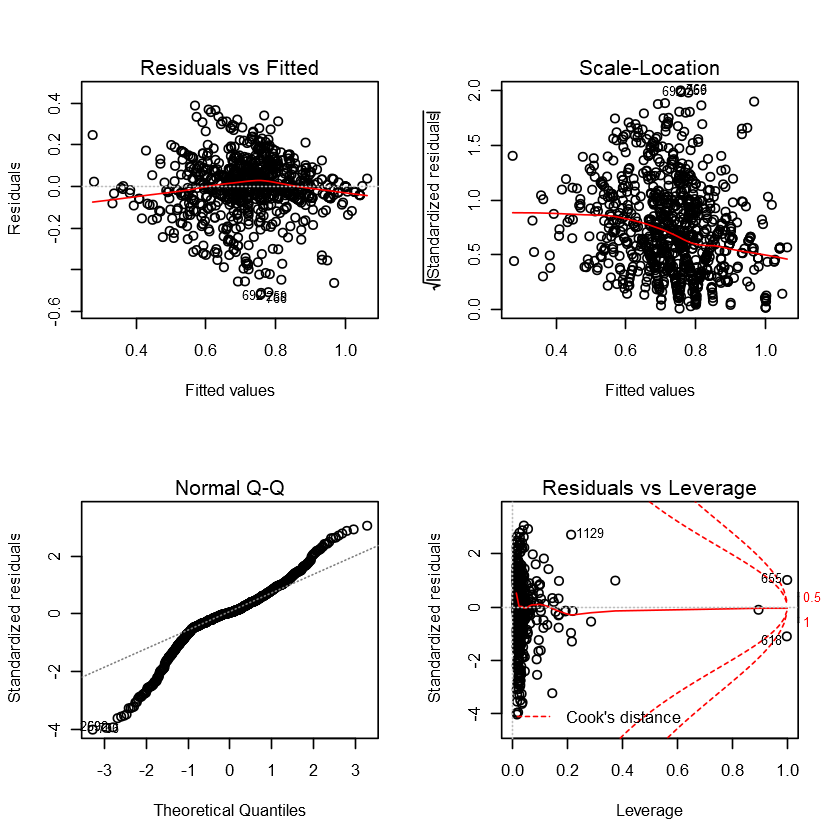

In [53]:
# Residuals plots
par(mfcol=c(2,2))
plot(fit2)

The **Residuals vs Fitted** show that the residuals are not quite evenly distributed around with points around the middle fluctuating further. The **Normal Q-Q** plot has more deviance outside of the range [-1, 1] than model 1 had so the residuals of model 2 are further from following a normal distribution. The **Scale-Location** shows fairly consistent variance of residuals although not perfect. The **Residuals vs Leverage** plot shows that there are a couple of influential outliers outside of Cook's line (655 and 618) but they should cancel each other out.

Next, we will use lasso regularisation to see if it can assist with feature selection by bringing some coefficients down to zero using a penalty term.

In [54]:
# Use the existing model and train data to create a matrix of features
model2 <- model.matrix(formula2, data = garments.train)
model2 <- model2[, -1] # remove intercept

In [55]:
# Fit lasso model with cross validation
set.seed(42)
cv.lasso <- cv.glmnet(model2, garments.train$actual_productivity, alpha = 1)

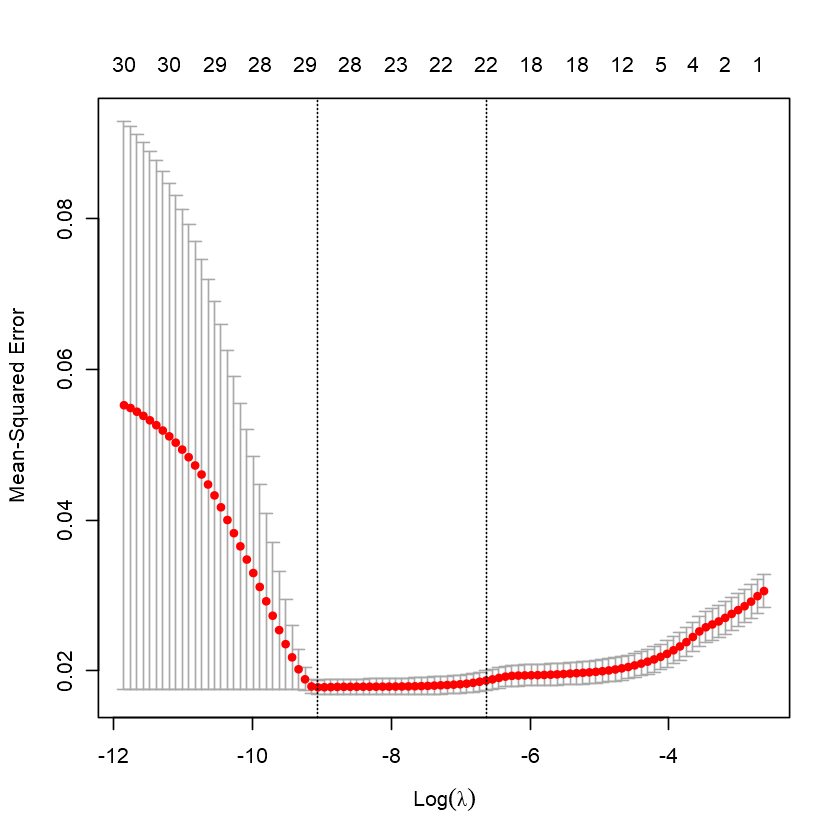

In [56]:
# Plot MSE against logarithm of lambda values
plot(cv.lasso)

From the plot, if we take log lambda of -8 we can simplify the model by about a quarter without increasing MSE by much from the minimum.

In [57]:
# Fit generalised linear model via a penalised maximum likelihood
fit2a <- glmnet(model2, garments.train$actual_productivity, alpha = 1)
# Set lambda from plot above and generate model
predict(fit2a, s = exp(-8), type = "coefficients")

31 x 1 sparse Matrix of class "dgCMatrix"
                                           1
(Intercept)                     3.532738e-01
departmentsewing                8.793591e-03
team2                          -2.472825e-02
team3                           .           
team4                           6.991188e-03
team5                           1.933841e-03
team6                          -8.087776e-02
team7                          -3.971815e-02
team8                          -5.745672e-02
team9                          -4.803177e-02
team10                         -5.594870e-02
team11                         -7.717347e-02
team12                         -3.002768e-02
targeted_productivity           4.246097e-01
smv                             .           
over_time                      -1.906323e-05
incentive                      -1.138746e-05
idle_time                       .           
idle_men                       -6.480636e-03
no_of_style_change              2.381794e-03
no_of_workers

The coefficients of a number of features such as **smv** and **idle_time** are now zero.

In this model, a one unit increase in the **targeted_productivity** contributes 0.4246 towards the predicted **actual_productivity**.

Other positive coefficients, which increase the predicted productivity as the variable increases include **department** (if the department is sewing), **no_of_style_change** (which had a negative effect in model 1) and **no_of_workers**. The following interactions of features also contribute to increases in predicted productivity:

- **department** (sewing) and **incentive**
- **department** (sewing) and **over_time**
- **over_time** and **incentive**
- **idle_time** and **idle_men**, however **idle_men** by itself has a negative impact on the estimation of productivity.

**over_time**, **incentive** and **idle_men** all have a negative relationship with the predictions of the productivity. In the case of incentive the magnitude is small and its interaction with **department** (sewing) also has a stronger positive effect. Most of the incentives are for the sewing department. The following interactions of features also contribute to decreases in predicted productivity:

- **department** (sewing) and **no_of_workers**
- **smv** and **no_of_workers**

If the productivity measure is for team 4 or 5, the estimation is slightly higher, for team 1 or 3, there is no effect, for all other teams the estimation is lower.

Test the model on the test data and calculate the RMSE:

In [58]:
# Create test data as matrix
model2.test <- model.matrix(formula2, data = garments.test)[,-1] # drop intercept

In [59]:
# Make predictions on test data using model 2
predictions2 <- predict(fit2a, s = exp(-8), newx = model2.test)

In [60]:
# Calculate RMSE of predictions
rmse2 <- rmse(predictions2, garments.test.label)
rmse2

[1] 0.1356835

In [61]:
# Calculate RMSE as a % of average actual_producitivity
round(rmse2/mean(garments.test.label),4)

[1] 0.1831

In [62]:
# Calculate MAE of predictions
mae2 <- mae(predictions2, garments.test.label)
mae2

[1] 0.09392863

In [63]:
# Calculate MAE as a % of average actual_producitivity
round(mae2/mean(garments.test.label),4)

[1] 0.1268

### Model 3

Now, we try to narrow down the features further and also try some transformations. We leave out **idle_men**, **idle_time** and **no_of_style_change** because of the high number of zero values in those features. We also leave out team, in order to simplify the model and because we aren't sure if it adds much to the model. We also leave out **date**, **quarter**, **day** and **wip** like we did in Model 2.

We also include a number of interactions with the **department** categorical variable due to the number of separate distributions of features as shown previously in the boxplots and density plots.

In [64]:
# Initial formula for model 3
formula3 <- actual_productivity ~ targeted_productivity + smv*department + incentive*department + 
            no_of_workers*department + over_time*department + smv:no_of_workers

# Fit initial linear model 3
fit3 <- lm(formula3, garments.train)
summary(fit3)


Call:
lm(formula = formula3, data = garments.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.52712 -0.03782  0.00932  0.05894  0.37647 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     7.022e-02  5.840e-02   1.202   0.2295    
targeted_productivity           4.161e-01  4.836e-02   8.604  < 2e-16 ***
smv                             5.713e-02  1.129e-02   5.061 5.01e-07 ***
departmentsewing                2.848e-01  1.297e-01   2.195   0.0284 *  
incentive                      -1.630e-05  2.512e-05  -0.649   0.5167    
no_of_workers                   2.014e-02  2.235e-03   9.015  < 2e-16 ***
over_time                      -2.813e-05  4.907e-06  -5.732 1.33e-08 ***
smv:departmentsewing           -6.416e-02  1.297e-02  -4.947 8.91e-07 ***
departmentsewing:incentive      3.785e-03  2.317e-04  16.337  < 2e-16 ***
departmentsewing:no_of_workers -2.075e-02  2.799e-03  -7.413 2.74e-13 ***
departmentsewi

Most of the coefficients are significant at the 0.001 level with **departmentsewing** significant at the 0.05 level. Only **incentive** and the interaction term between **smv** and **no_of_workers** are not significant.

In [65]:
set.seed(42)

# Set 5 folds (90/10 splits) for cross validation
cv <- trainControl(method = "cv", number = 10)

# Re-create model for cross-validation 
train(formula3, data = garments.train, method = "lm", trControl = cv)

Linear Regression 

958 samples
  6 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 863, 861, 862, 861, 862, 863, ... 
Resampling results:

  RMSE       Rsquared   MAE       
  0.1330592  0.4257728  0.09118546

Tuning parameter 'intercept' was held constant at a value of TRUE

On cross-validation the RMSE and $R^2$ shows an improvement on previous models. It is worth also trying some transformations of features.

First we try some log transformation of features **smv**, **incentive**, and **over_time** based on the histograms of log distributions performed in EDA:

In [66]:
# Try with some log transformations
formula3a <- actual_productivity ~ targeted_productivity + log(smv)*department + log(incentive+1)*department + 
            no_of_workers*department + log(over_time+1)*department + log(smv):no_of_workers

fit3a <- lm(formula3a, garments.train)
summary(fit3a)


Call:
lm(formula = formula3a, data = garments.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.55020 -0.05164  0.00406  0.06858  0.41939 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          0.424670   0.125825   3.375 0.000768 ***
targeted_productivity                0.526139   0.048407  10.869  < 2e-16 ***
log(smv)                             0.243714   0.048419   5.033 5.77e-07 ***
departmentsewing                    -0.237459   0.349696  -0.679 0.497276    
log(incentive + 1)                  -0.082406   0.017429  -4.728 2.61e-06 ***
no_of_workers                        0.021194   0.004052   5.230 2.08e-07 ***
log(over_time + 1)                  -0.081133   0.015979  -5.077 4.61e-07 ***
log(smv):departmentsewing           -0.273508   0.117146  -2.335 0.019765 *  
departmentsewing:log(incentive + 1)  0.140885   0.017938   7.854 1.09e-14 ***
departmentsewing:no_of_workers      -0.018447  

The metrics of the model are worse than before ($R^2$ and RSE have increased and F-stat has decreased) so we will try a few other transformations.

In the model below, the transformation **$\frac{1}{smv}$** is from the splom where **incentive** was set to 0, it looked like a non-linear relationship might exist. There looked to be a non-linear relationship between **smv** and **no_of_workers** so we include an interaction term with a transformation. The relationship between the target variable, **actual_productivity** and **incentive** also looked non-linear. Finally, the scatterplots possibly suggested a non-linear relationship between **targeted_productivity** and **actual_productivity** so we trial a squared transformation.

In [67]:
# Update model 3 formula
formula3b <- actual_productivity ~ department*smv + I(1/smv) + sqrt(incentive)*department + 
            no_of_workers*department + over_time*department + smv:I(no_of_workers^2) + I(targeted_productivity^2)

# Fit
fit3b <- lm(formula3b, garments.train)
summary(fit3b)


Call:
lm(formula = formula3b, data = garments.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.56621 -0.03649  0.00217  0.06135  0.38641 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       2.794e+00  3.480e-01   8.030 2.89e-15 ***
departmentsewing                 -1.584e+00  2.648e-01  -5.981 3.15e-09 ***
smv                              -2.960e-01  4.771e-02  -6.203 8.29e-10 ***
I(1/smv)                         -4.745e+00  6.222e-01  -7.625 5.94e-14 ***
sqrt(incentive)                  -8.955e-04  1.132e-03  -0.791 0.429113    
no_of_workers                     1.925e-02  2.121e-03   9.076  < 2e-16 ***
over_time                        -2.708e-05  4.810e-06  -5.630 2.38e-08 ***
I(targeted_productivity^2)        3.924e-01  3.752e-02  10.456  < 2e-16 ***
departmentsewing:smv              2.680e-01  4.508e-02   5.945 3.88e-09 ***
departmentsewing:sqrt(incentive)  3.268e-02  2.394e-03  13.651  < 2

The $R^2$ of 0.4592 compared to the 0.4343 of the original model means that this model explains an additional 4.4% of the variation in the actual productivity relative to the previous iteration of the model ($\frac{0.4592 - 0.4343}{1-0.4343}$). 

The **F-statistic** of 66.86 is greater than 1 and the p-value is extremely small so the model is significant, there is a relationship between the target variable and the predictors.

The only coefficient that is not significant is for the non-linear incentive feature however as it is also included as an interaction in the model, we will leave it in the model. In addition:

- The coefficient of **targeted_productivity** squared shows the positive relationship with **actual_productivity**.
- **Department** (sewing) has a negative impact on predicted **actual_productivity** but its interactions with **smv**, the square root of **incentive** and **over_time** are both positive. Its interaction with **no_of_workers** also has a negative impact on the target.
- Square root of **incentive** has a negative coefficient but as previously mentioned, the interaction with **department** (sewing) is positive. The magnitude of the interaction term is greater than **sqrt(incentive)**. In the case of **sqrt(incentive)**, we also cannot conclude that the coefficient is not zero.
- Despite the negative coefficient of the interaction term of **no_of_workers** and **department** (sewing), the coefficient of **no_of_workers** by itself is positive but slightly smaller in magnitude. Ignoring the interaction with **smv**, if the department is sewing, more workers lead to a negative impact on productivity while for finishing, more workers has a positive impact on productivity. The interaction of its squared value with **smv** is also positive.
- Despite the positive coefficient of the interaction term of **over_time** aand **department** (sewing), the coefficient of **over_time** by itself is negative and slighly larger in magnitude. It seems more **over_time** also points to lower productivity, especially for the finishing department.
- **smv** has a negative relationship with **actual_productivity** but this can be partly offset if the department is the sewing department and/or there are more workers.

The negative impact of the sewing department on productivity is consistent with the boxplots in EDA but can be mitigated with enough of a financial incentive.

In [68]:
set.seed(42)

# Set 10 folds (90/10 splits) for cross validation
cv <- trainControl(method = "cv", number = 10)

# Re-create model for cross-validation 
train(formula3b, data = garments.train, method = "lm", trControl = cv)

Linear Regression 

958 samples
  6 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 863, 861, 862, 861, 862, 863, ... 
Resampling results:

  RMSE       Rsquared   MAE       
  0.1301632  0.4514937  0.08781399

Tuning parameter 'intercept' was held constant at a value of TRUE

The cross-validated $R^2$ has improved and the RMSE has dropped. Next, we check the residuals:

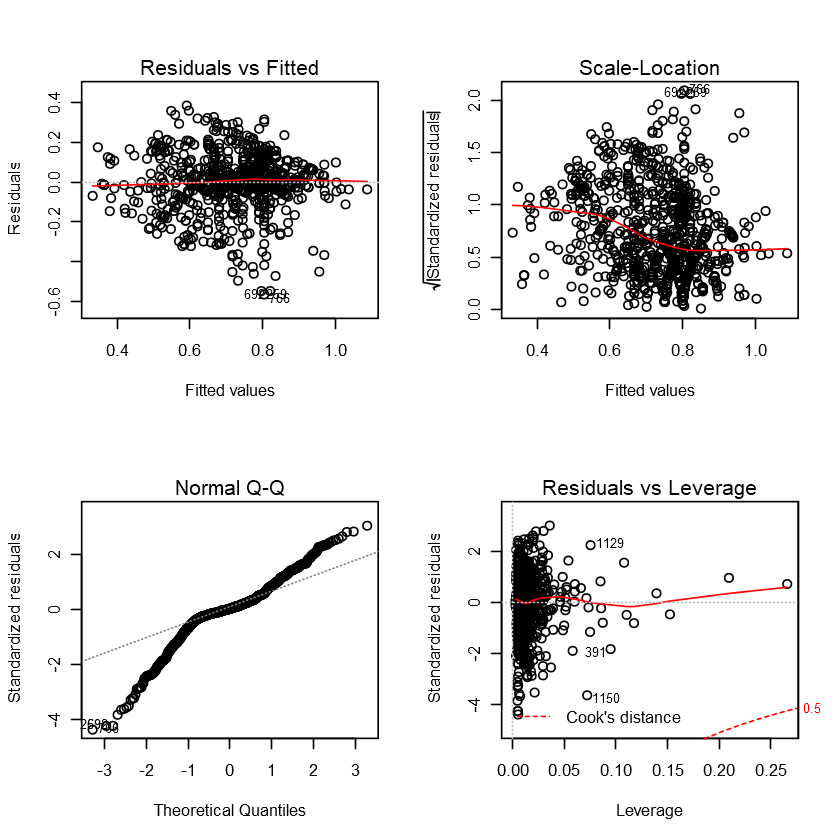

In [69]:
par(mfcol=c(2,2))
plot(fit3b)

Similar to the previous models the **Residuals vs Fitted** show that the residuals are perhaps not quite evenly distributed although it is not too bad. Also similar to the previous models, the standardised residuals on the **Normal Q-Q** plot deviate from a normal distribution above theoretical quantile 1 and below theoretical quantile -1. The **Scale-Location** shows consistent variance of residuals and the **Residuals vs Leverage** plot does not show any points outside Cook's distance.

We can then make predictions on the test set and calculate the rmse:

In [70]:
# Make predictions on test data using linear model 3
predictions3 <- predict(fit3b, garments.test, method = "response")

In [71]:
# Calculate RMSE of predictions
rmse3 <- rmse(predictions3, garments.test.label)
rmse3

[1] 0.1334158

In [72]:
# Calculate RMSE as a % of average actual_producitivity
round(rmse3/mean(garments.test.label),4)

[1] 0.1801

In [73]:
# Calculate MAE of predictions
mae3 <- mae(predictions3, garments.test.label)
mae3

[1] 0.08876788

In [74]:
# Calculate MAE as a % of average actual_producitivity
round(mae3/mean(garments.test.label),4)

[1] 0.1198

### Random Forest Regressor

Using a slightly modified version of the formula3b model we can easily fit a basic random forest regressor model to the data and compare the accuracy of the predictions.

In [75]:
# Adapt formula3b
formula4 <- actual_productivity ~ department*smv + incentive*department + 
            no_of_workers*department + over_time*department + smv:I(no_of_workers^2) + 
            targeted_productivity^2

In [76]:
# Fit randomForest model with 1000 trees
set.seed(42)
fit4 <- randomForest(formula4, garments.train, ntree = 1000)

In [77]:
# Make predictions on test data using RF model
predictions4 <- predict(fit4, garments.test, method = "anova")

In [78]:
# Calculate RMSE of predictions
rmse4 <- rmse(predictions4, garments.test.label)
rmse4

[1] 0.1224667

In [79]:
# Calculate RMSE as a % of average actual_producitivity
round(rmse4/mean(garments.test.label),4)

[1] 0.1653

In [80]:
# Calculate MAE of predictions
mae4 <- mae(predictions4, garments.test.label)
mae4

[1] 0.07228183

In [81]:
# Calculate MAE as a % of average actual_producitivity
round(mae4/mean(garments.test.label),4)

[1] 0.0976

## 5. Results and discussion <a class="anchor" id="sec_6"></a>

The results of the predictions of each model on the test data are presented in the table below:

|Model|RMSE|% of mean of test actual_productivity|MAE|% of mean of test actual_productivity|Number of predictors
|--------|--------|-------|--------|--------|--------
1|0.1416|19.11|0.1023|0.1381|24
2|0.1357|18.31|0.0939|0.1268|23
3|0.1334|18.01|0.0887|11.98|12
RF|0.1225|16.53|0.0723|9.76|-

Each subsequent model performed better in terms of overall predictive power of the test set using the root mean square error or mean absolute error as the metric. None of the regression models are able to produce models with very strong fits in terms of their $R^2$ values (all were less than 0.5) but at least did not have much overfitting as confirmed by cross-validation.

The main advantage of **model 1** is that it is the easiest to understand. There are no transformations or interactions of the features so it is very easy to infer how each variable interacts with the response variable. Unfortunately it is too simplistic and performs the worst as well as having the higest number of features of the three linear models.

**Model 2** performs better than model 1 and has 1 less predictor variable after applying a penalty term from lasso regularisation, which reduces various coefficients to zero. The model has some interaction terms but is still interpretable.

**Model 3** performed slightly better than model 2 using the RMSE metric on the test set. It also had only about half as many features in the model, many of which were interaction and/or transformation features between a smaller subset of the attributes of the data. It is a little bit harder to intepret than models 1 or 2 but, being a linear model, it is still quite interpretable.

All three models performed worse than a random forest regression model that used almost the exact same features as model 3. While the random forest regressor performed better at making predictions of productivity, the model is not intepretable and so is not very useful for inference.

Another issue with the linear models were the Normal Q-Q plots which, especially for models 2 & 3, deviated a fair bit from a normal distribution in some parts of the plot. This could make the results of the regression models questionable but the size of the dataset should be adequate that some reliance can still be placed on the models.

### Best attributes
The best attribute for predicting the actual productivity was the **targeted productivity**. This variable featured in all regression models, was always significant at any level and often had the largest coefficient in the model. The correlation and scatterplot matrices also showed that it had the strongest correlation with productivity. 

The **department** attribute also has a significant impact on the prediction of actual productivity, due to its interaction with several other attributes due to the different distributions of attributes by department. **Incentive** was a good example of this as it has a clear correlation with productivity but most of the incentives are offered to the sewing department so the relationship was only clear when considering the interaction (i.e. its impact is strong as an interaction term with department, rather than on its own, which can be seen by the p-values in various iterations of the models including the final model 3). The predictions would be significantly more accurate if they were only for the sewing department and/or where an incentive is offered.

The other attributes that impacted the prediction of productivity were **smv**, **over_time** and **no_of_workers**. From the scatterplot and correlation matrices, these attributes had strong positive correlations with each other but did not appear to have much correlation with productivity. As interaction terms their coefficients typically displayed statistical significance (e.g. see model 3).

## 6. Conclusion<a class="anchor" id="sec_7"></a>

Form the EDA we discovered that the strongest correlation with the response variable **actual_productivity** was **targeted_productivity**. We also discovered that a number of attributes displayed different distributions based on the **department**. Certain attributes such as **smv**, **over_time** and **no_of_workers** displayed correlation between them.

From the EDA, three linear regression models of varying complexity were built, using stepwise selection and lasso regularisation for feature selection as well as a manual approach using judgement. Of the three models, the third model, which had the least number of features, performed the best on the test set using RMSE. The models were compared to a random forest regressor model, which performed noticeably better but from which inferences could not be made.

The best attribute for impacting the prediction of **actual_productivity** was **target_productivity**. The other most useful predictors were **department**, **incentive**, **smv**, **over_time** and **no_of_workers**.